Keras implementation of combined Conditional VAE and Auxiliary-Classifier GAN.

* The combined VAE-GAN is partially inspired from the paper "Autoencoding beyond pixels using a learned similarity metric" with major modifications.

* Keras tricks to train GAN is ispired from https://github.com/keras-team/keras/issues/8585 and https://github.com/eriklindernoren/Keras-GAN

# Environment Setup

## Modules

In [2]:
# imports
### Disable tensorflow 2.0
%tensorflow_version 1.x
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

from __future__ import print_function, division
from builtins import range, input
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Activation, Dropout, Reshape, Add, Multiply, MaxPooling2D, AveragePooling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import plot_model
from keras import backend as K
## added to plot model in google colab
from IPython.display import Image

TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
import os
from datetime import datetime

import imageio

In [4]:
import sys
sys.path

['/tensorflow-1.15.2/python3.7',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [5]:
root = "/drive/MyDrive/FHNW/galaxy_generator/"
root_output = root + "keras/"
# append path if needed
sys.path.append(root)

## Parameters

In [6]:
# Encoder parameters
img_dim = 64
colors = 3
labels_dim = 3
latent_dim = 8
dec_dim = latent_dim # default equals to latent_dim. (different in case PCA is applied before decoder, not used here)
filter_size = 3

In [7]:
# General parameters
ALPHA = 1 # to switch from VAE (1) to AE (0)
BETA = 1 # for beta-VAE (weight for KL). Default is 1
ZETA = 1/2 # for combined GAN VAE with MSE loss (weight for MSE)
DELTA = 1 # for the auxiliary classifier at the output of GAN
GAMMA = 1024 # for learned metric (https://arxiv.org/pdf/1512.09300.pdf)
optimizer = Adam(0.0002, 0.5) #RMSprop()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Useful functions

In [8]:
## plot network
def summarize(network):
    # summary of the encoder
    network.summary()
    # plot model
    plot_model(network, to_file='network.png', show_shapes=True, show_layer_names=True)
    display(Image(retina=True, filename='network.png'))



# Networks

## Discriminator

### Discriminator 1

In [9]:
# GAN Discriminator 1
input_disc = Input(shape=(img_dim,img_dim,colors,), name="disc_input")
h_disc = Conv2D(filters= 8, kernel_size=3, strides=2, padding='same', activation="relu", name="disc_conv_1_activated")(input_disc)
h_disc = Conv2D(filters= 16, kernel_size=3, strides=2, padding='same', name="disc_conv_2_no-activation")(h_disc)
h_disc = BatchNormalization(name="disc_batchNorm_1")(h_disc)
h_disc = Activation(activation="relu", name="disc_relu_1")(h_disc)
## new
h_disc = Conv2D(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="disc_conv_3_activated")(h_disc)
h_disc = Conv2D(filters= 64, kernel_size=3, strides=2, padding='same', activation="relu", name="disc_conv_4_activated")(h_disc)
#h = Conv2D(filters= 2*latent_dim, kernel_size=4, strides=1, padding='valid', name="enc_conv_5_no-activation")(h) # exactly equivalent to FC
f_disc = Flatten(name="disc_flatten")(h_disc)
## additional dense layer for dimensionality reduction
d_disc = Dense(256, activation ="relu", name="disc_dense_1_mean_activated")(f_disc)
##
out_disc = Dense(1, activation="sigmoid", name="disc_dense_2_std_activated")(d_disc)
##

#f = Flatten(name="enc_flatten")(h)
#d = Dense(100,name="enc_dense_1_no-activation")(f)
#d = BatchNormalization(name="enc_batchNorm_2")(d)
#d = Activation(activation="relu", name="enc_relu_2")(d)
#z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
#z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

## new
#z_mu = Lambda(lambda x : x[:,:latent_dim], name="enc_split_1")(f)
#z_std = Lambda(lambda x : x[:,latent_dim:], name="enc_split_2")(f)
#z_std = Activation(activation="softplus", name="enc_sofplus")(z_std)
##

discriminator_1 = Model(inputs=input_disc, outputs=out_disc, name="discriminator")

### Discriminator 3

In [10]:
# GAN Discriminator 3
img = Input(shape=(img_dim,img_dim,colors,), name="D_in")
# Conv from image
h = Conv2D(32, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(64, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(128, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
h = Flatten()(h)
# Dense 1
h = Dense(1024)(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Dense 2
D_out = Dense(1, activation='sigmoid', name="D_out")(h)
        
discriminator_3 = Model(img,D_out,name="discriminator")

### Discriminator 4

In [11]:
# GAN Discriminator 4 (disriminator with auxiliary classifier and learned metric output)
img = Input(shape=(img_dim,img_dim,colors,), name="D_in_metric")
# Conv from image
h = Conv2D(16, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(32, kernel_size = filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(64, kernel_size = filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 3
h = Conv2D(128, kernel_size = filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
h = Flatten()(h)
# Dense 1
h = Dense(1024)(h)
h = BatchNormalization(momentum=0.99)(h)
h_metric = LeakyReLU(alpha=0.2)(h)
discriminator_metric = Model(img,h_metric,name="discriminator_metric")


img_disc = Input(shape=(img_dim,img_dim,colors,), name="D_in")

##  features
metric_disc = discriminator_metric(img_disc)  

# Dense 2
## true/fake
D_out = Dense(1, activation='sigmoid', name="D_out_adv")(metric_disc)
## labels
D_out_labels = Dense(labels_dim, activation='softmax', name="D_out_labels")(metric_disc)
#discriminator_4 = Model(img,[D_out,D_out_labels],name="discriminator")
discriminator_4 = Model(img_disc,concatenate([D_out,D_out_labels,metric_disc]),name="discriminator")

### Summary

In [12]:
discriminator = discriminator_4

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
D_in (InputLayer)               (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
discriminator_metric (Model)    (None, 1024)         8491680     D_in[0][0]                       
__________________________________________________________________________________________________
D_out_adv (Dense)               (None, 1)            1025        discriminator_metric[1][0]       
__________________________________________________________________________________________________
D_out_labels (Dense)            (None, 3)            3075        discriminator_metric[1][0]       
______________________________________________________________________________________

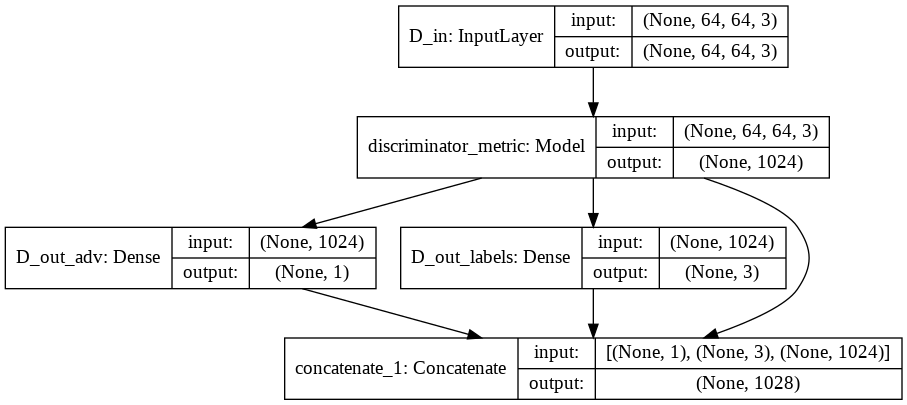

In [13]:
# summary of the discriminator
discriminator.summary()
# plot model
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='discriminator.png')

## Encoder

### Encoder 1

In [14]:
# VAE encoder 1
input_enc = Input(shape=(img_dim,img_dim,colors,), name="enc_input")
h = Conv2D(filters= 8, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_1_activated")(input_enc)
h = Conv2D(filters= 16, kernel_size=3, strides=2, padding='same', name="enc_conv_2_no-activation")(h)
h = BatchNormalization(name="enc_batchNorm_1")(h)
h = Activation(activation="relu", name="enc_relu_1")(h)
## new
h = Conv2D(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_3_activated")(h)
h = Conv2D(filters= 64, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_4_activated")(h)
#h = Conv2D(filters= 2*latent_dim, kernel_size=4, strides=1, padding='valid', name="enc_conv_5_no-activation")(h) # exactly equivalent to FC
f = Flatten(name="enc_flatten")(h)
## additional dense layer for dimensionality reduction
d = Dense(256, activation ="relu", name="enc_dense_1_mean_activated")(f)
##
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d) #only for VAE
##

#f = Flatten(name="enc_flatten")(h)
#d = Dense(100,name="enc_dense_1_no-activation")(f)
#d = BatchNormalization(name="enc_batchNorm_2")(d)
#d = Activation(activation="relu", name="enc_relu_2")(d)
#z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
#z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

## new
#z_mu = Lambda(lambda x : x[:,:latent_dim], name="enc_split_1")(f)
#z_std = Lambda(lambda x : x[:,latent_dim:], name="enc_split_2")(f)
#z_std = Activation(activation="softplus", name="enc_sofplus")(z_std)
##
if ALPHA:
  encoder_1 = Model(inputs=input_enc, outputs=[z_mu,z_std], name="encoder")
else:
  encoder_1 = Model(inputs=input_enc, outputs=z_mu, name="encoder")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
enc_conv_1_activated (Conv2D)   (None, 32, 32, 8)    224         enc_input[0][0]                  
__________________________________________________________________________________________________
enc_conv_2_no-activation (Conv2 (None, 16, 16, 16)   1168        enc_conv_1_activated[0][0]       
__________________________________________________________________________________________________
enc_batchNorm_1 (BatchNormaliza (None, 16, 16, 16)   64          enc_conv_2_no-activation[0][0]   
____________________________________________________________________________________________

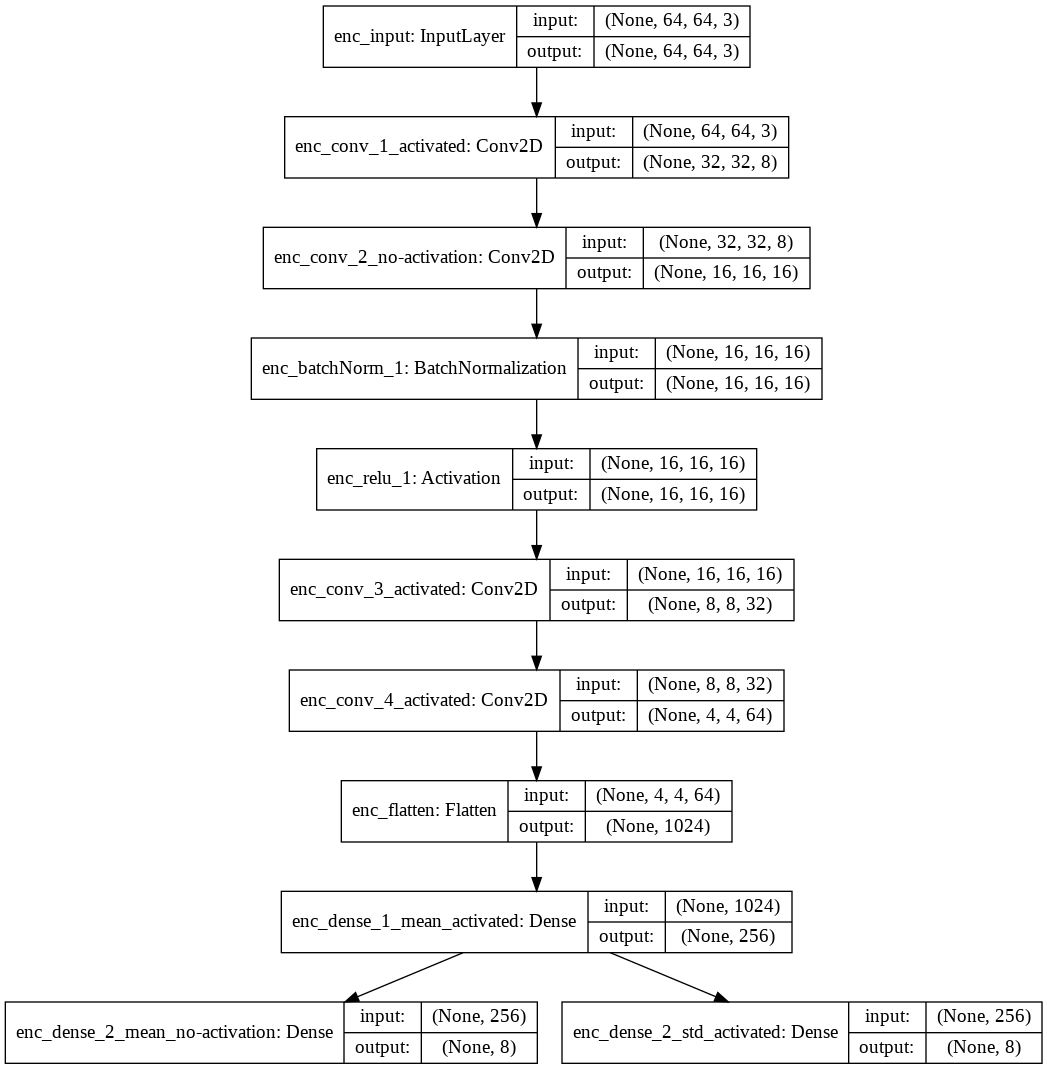

In [15]:
summarize(encoder_1)

### Encoder 2

In [16]:
# VAE encoder 2 - Inception units
input_enc = Input(shape=(img_dim,img_dim,colors,), name="enc_input")
## inception 1
inc1_1 = Conv2D(filters= 4, kernel_size=1, strides=1, padding='same', activation="relu")(input_enc)
inc1_2 = Conv2D(filters= 4, kernel_size=3, strides=1, padding='same', activation="relu")(input_enc)
h = concatenate([inc1_1,inc1_2])

h = Conv2D(filters= 8, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_1_activated")(h)

## inception 2
inc2_1 = Conv2D(filters= 8, kernel_size=1, strides=1, padding='same', activation="relu")(h)
inc2_2 = Conv2D(filters= 8, kernel_size=3, strides=1, padding='same', activation="relu")(h)
h = concatenate([inc2_1,inc2_2])

h = Conv2D(filters= 16, kernel_size=3, strides=2, padding='same', name="enc_conv_2_no-activation")(h)
h = BatchNormalization(name="enc_batchNorm_1")(h)
h = Activation(activation="relu", name="enc_relu_1")(h)

## inception 3
inc3_1 = Conv2D(filters= 16, kernel_size=1, strides=1, padding='same', activation="relu")(h)
inc3_2 = Conv2D(filters= 16, kernel_size=3, strides=1, padding='same', activation="relu")(h)
h = concatenate([inc3_1,inc3_2])

h = Conv2D(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_3_activated")(h)

## inception 4
inc4_1 = Conv2D(filters= 32, kernel_size=1, strides=1, padding='same', activation="relu")(h)
inc4_2 = Conv2D(filters= 32, kernel_size=3, strides=1, padding='same', activation="relu")(h)
h = concatenate([inc4_1,inc4_2])

h = Conv2D(filters= 64, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_4_activated")(h)

f = Flatten(name="enc_flatten")(h)
## additional dense layer for dimensionality reduction
d = Dense(256, activation ="relu", name="enc_dense_1_mean_activated")(f)
##
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

if ALPHA:
  encoder_2 = Model(inputs=input_enc, outputs=[z_mu,z_std], name="encoder")
else:
  encoder_2 = Model(inputs=input_enc, outputs=z_mu, name="encoder")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 4)    16          enc_input[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 4)    112         enc_input[0][0]                  
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 64, 64, 8)    0           conv2d_8[0][0]                   
                                                                 conv2d_9[0][0]             

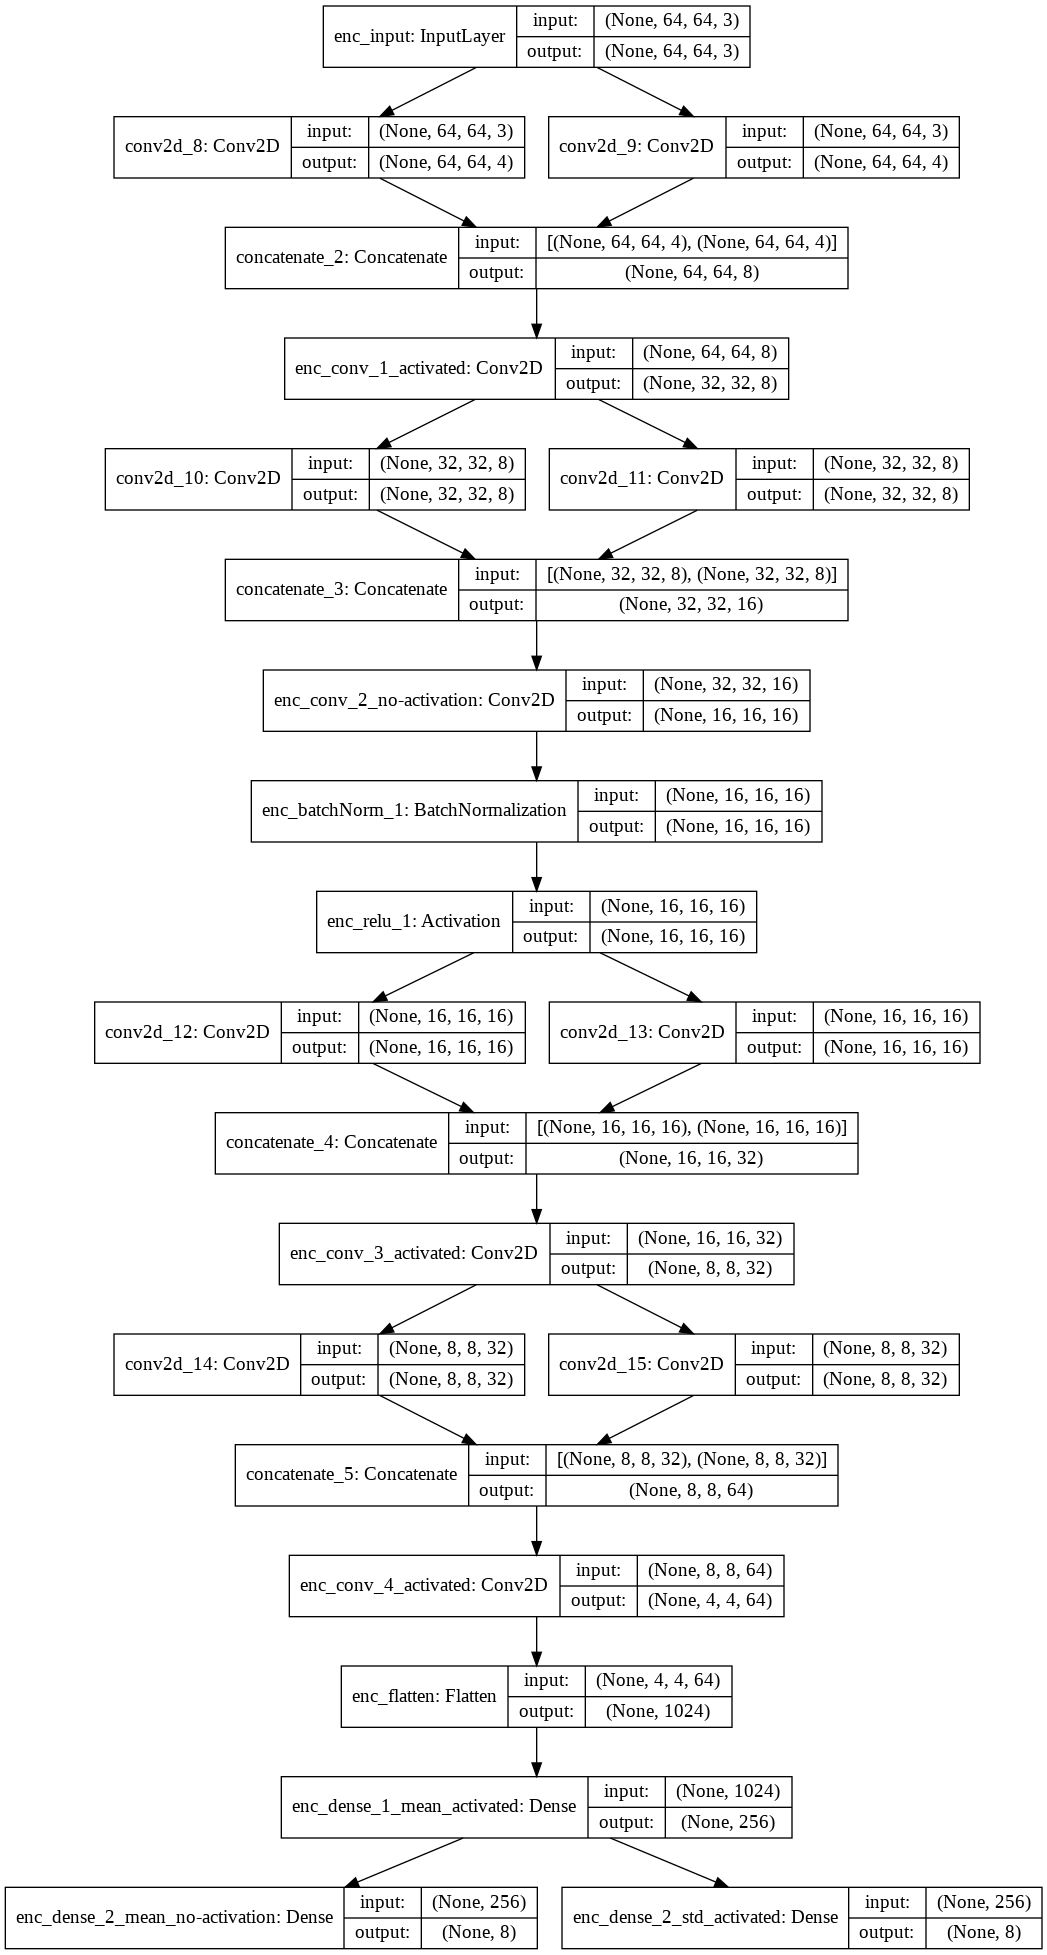

In [17]:
summarize(encoder_2)

### Encoder 3

In [18]:
# encoder 3
img = Input(shape=(img_dim,img_dim,colors,), name="enc_in")
# Conv from image
h = Conv2D(32, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(64, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(128, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
f = Flatten()(h)
# Dense 1
d = Dense(1024)(f)
d = BatchNormalization(momentum=0.99)(d)
d = LeakyReLU(alpha=0.2)(d)
# Dense 2
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

if ALPHA:
  encoder_3 = Model(inputs=img, outputs=[z_mu,z_std], name="encoder")
else:
  encoder_3 = Model(inputs=img, outputs=z_mu, name="encoder")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 32)   128         enc_in[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 64, 64, 32)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 64)   51264       leaky_re_lu_10[0][0]             
____________________________________________________________________________________________

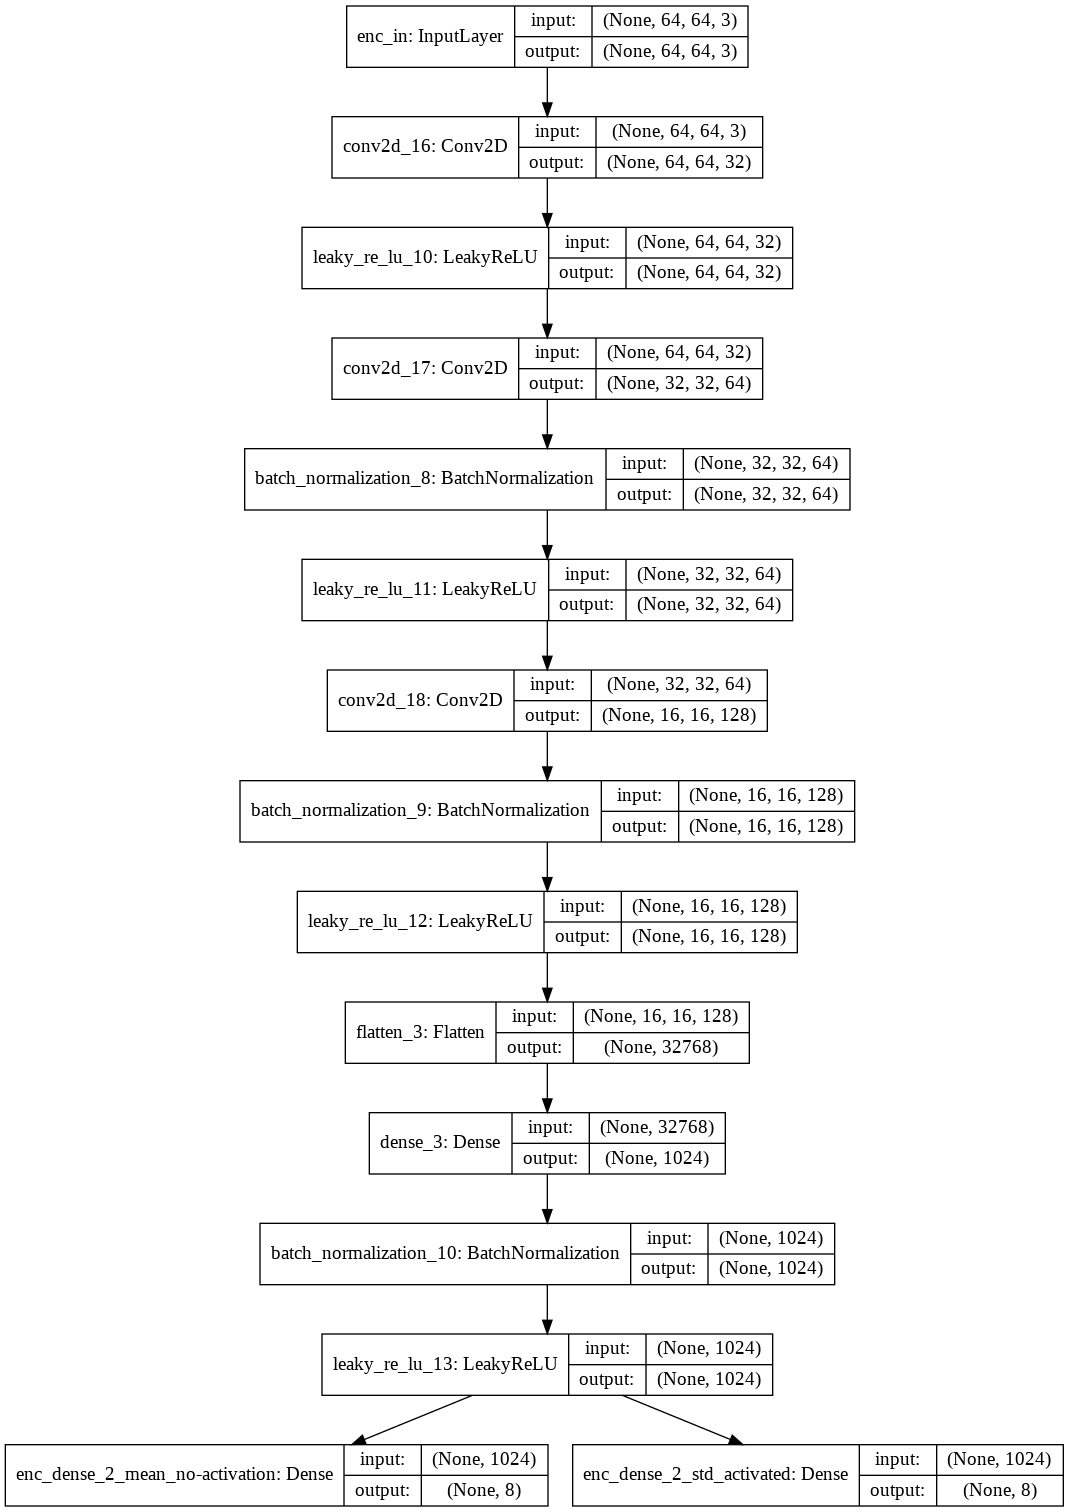

In [19]:
summarize(encoder_3)

### Encoder 4

In [20]:
# encoder 4
img = Input(shape=(img_dim,img_dim,colors,), name="enc_in")
input_enc_labels = Input(shape=(labels_dim,), name="enc_input_labels")
# Conv from image
h = Conv2D(16, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(32, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(64, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 3
h = Conv2D(128, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
f = Flatten()(h)
## add labels
f_c = concatenate([f,input_enc_labels])
# Dense 1
d = Dense(1024)(f_c)
d = BatchNormalization(momentum=0.99)(d)
d = LeakyReLU(alpha=0.2)(d)
# Dense 2
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

if ALPHA:
  encoder_4 = Model(inputs=[img,input_enc_labels], outputs=[z_mu,z_std], name="encoder")
else:
  encoder_4 = Model(inputs=[img,input_enc_labels], outputs=z_mu, name="encoder")

<

In [21]:
encoder = encoder_4

### Summary

In [22]:
# track the dimension before and after flattening
dim_pre_flatten = h._keras_shape[1:]
dim_post_flatten  = f._keras_shape[1]
print(dim_pre_flatten,dim_post_flatten)

(8, 8, 128) 8192


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 16)   64          enc_in[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 64, 64, 16)   0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 32)   4640        leaky_re_lu_14[0][0]             
____________________________________________________________________________________________

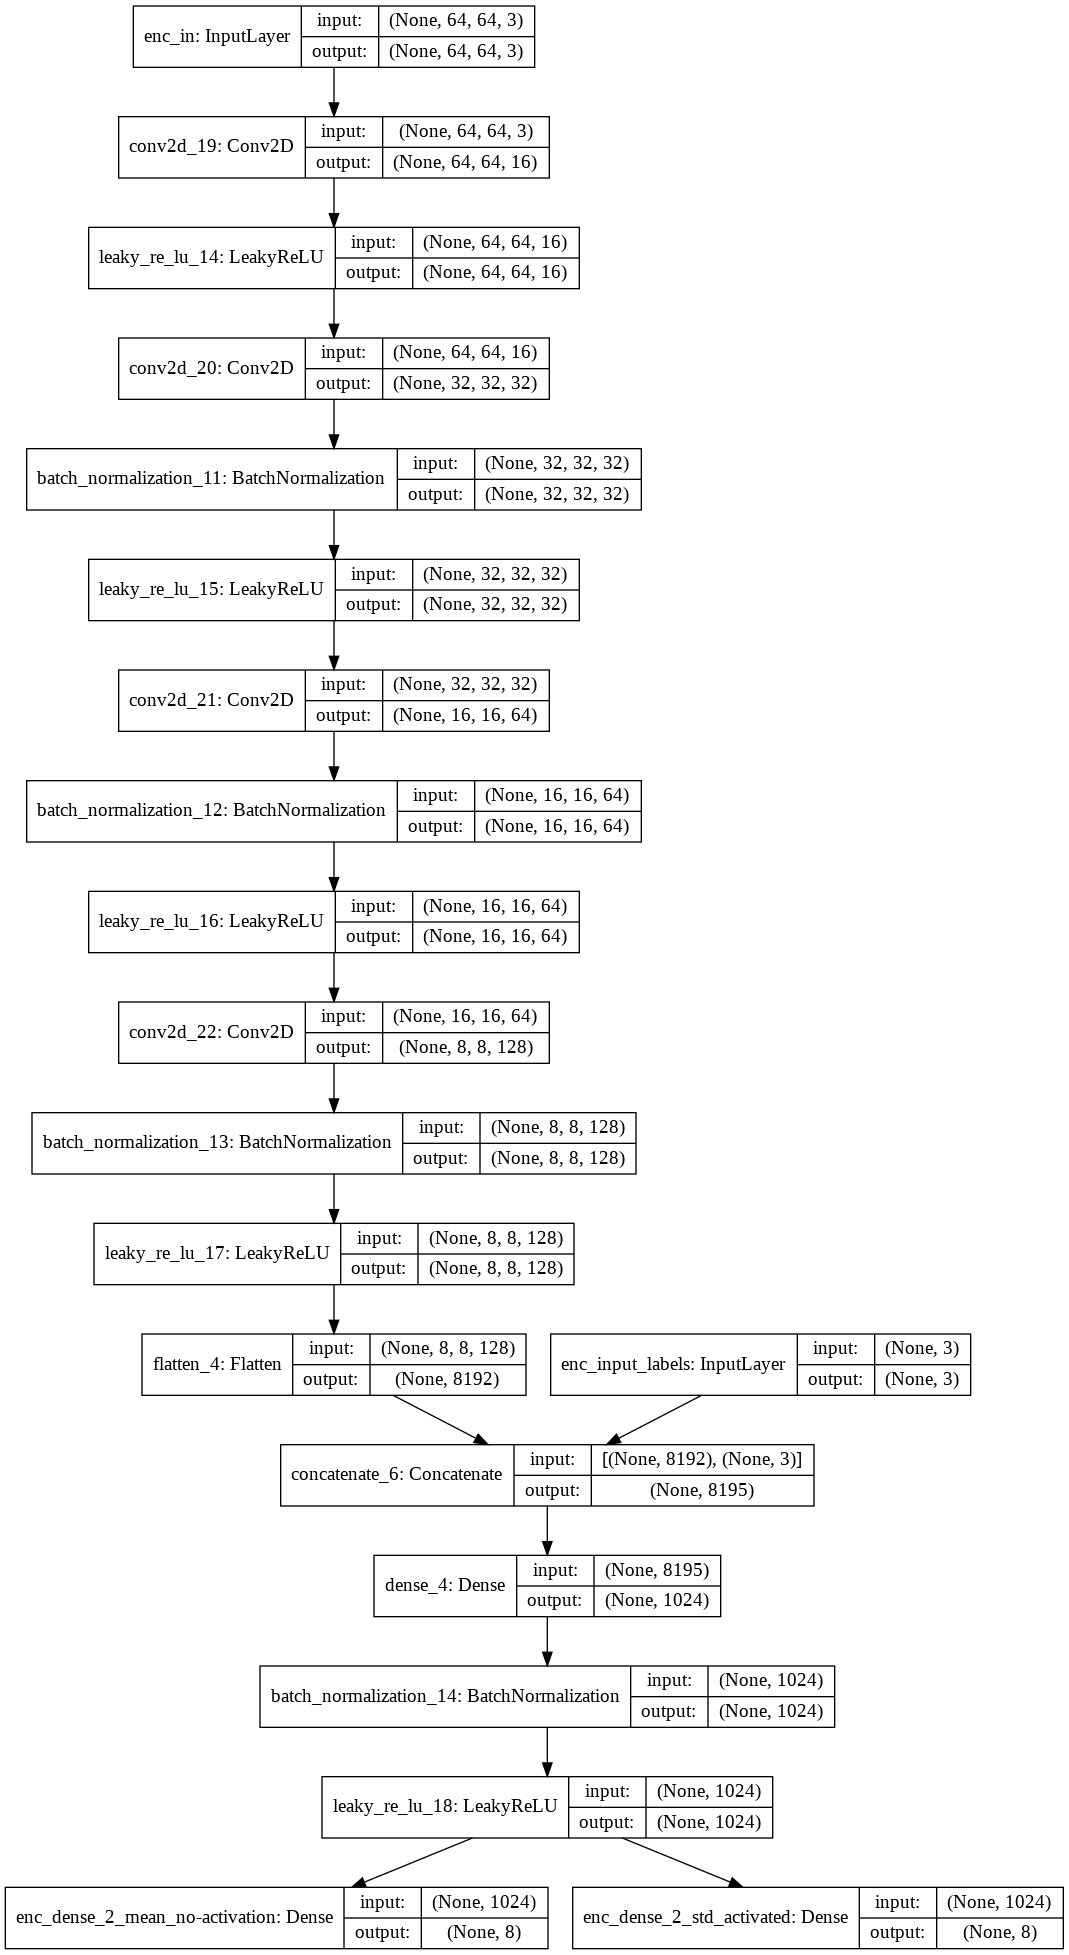

In [23]:
# summary of the encoder
encoder.summary()
# plot model
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='encoder.png')

## Decoder

### Decoder 1

In [24]:
# VAE decoder 1
input_dec = Input(shape=(dec_dim,), name="dec_input")
#h_d = Dense(100, activation="relu", name="dec_dense_1_activated")(input_dec)
#h_d = Dense(dim_post_flatten, name="dec_dense_2_no-activation")(h_d)
#h_d = BatchNormalization(name="dec_batchNorm_1")(h_d)
#h_d = Activation(activation="relu", name="dec_relu_1")(h_d)
#h_d = Reshape(dim_pre_flatten,name="dec_reshape")(h_d)

##new
h_d = Dense(dim_post_flatten, name="dec_dense_2_no-activation")(input_dec)
h_d = BatchNormalization(name="dec_batchNorm_1")(h_d)
h_d = Activation(activation="relu", name="dec_relu_1")(h_d)
h_d = Reshape(dim_pre_flatten,name="dec_reshape")(h_d)
#h_d = Reshape((dim_pre_flatten[0],dim_pre_flatten[1],dim_pre_flatten[2]//2),name="dec_reshape")(input_dec)
#h_d = Conv2DTranspose(filters= 64, kernel_size=4, strides=1, padding='valid', activation="relu", name="dec_trans-conv_1_activated")(h_d) # almost equivalent to FC (less bias terms)
h_d = Conv2DTranspose(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_2_activated")(h_d)
h_d = Conv2DTranspose(filters= 16, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_3_activated")(h_d)
##
h_d = Conv2DTranspose(filters= 8, kernel_size=3, strides=2, padding='same', name="dec_trans-conv_4_no-activation")(h_d)
h_d = BatchNormalization(name="dec_batchNorm_2")(h_d)
h_d = Activation(activation="relu", name="dec_relu_2")(h_d)
h_d = Conv2DTranspose(filters= colors, kernel_size=3, strides=2, padding='same', activation="sigmoid", name="dec_trans-conv_5_activated")(h_d) # the activation depends on the data normalization (sigmoid or tanh)
decoder_1 = Model(inputs=input_dec, outputs = h_d, name="decoder")

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_input (InputLayer)       (None, 8)                 0         
_________________________________________________________________
dec_dense_2_no-activation (D (None, 8192)              73728     
_________________________________________________________________
dec_batchNorm_1 (BatchNormal (None, 8192)              32768     
_________________________________________________________________
dec_relu_1 (Activation)      (None, 8192)              0         
_________________________________________________________________
dec_reshape (Reshape)        (None, 8, 8, 128)         0         
_________________________________________________________________
dec_trans-conv_2_activated ( (None, 16, 16, 32)        36896     
_________________________________________________________________
dec_trans-conv_3_activated ( (None, 32, 32, 16)        4624

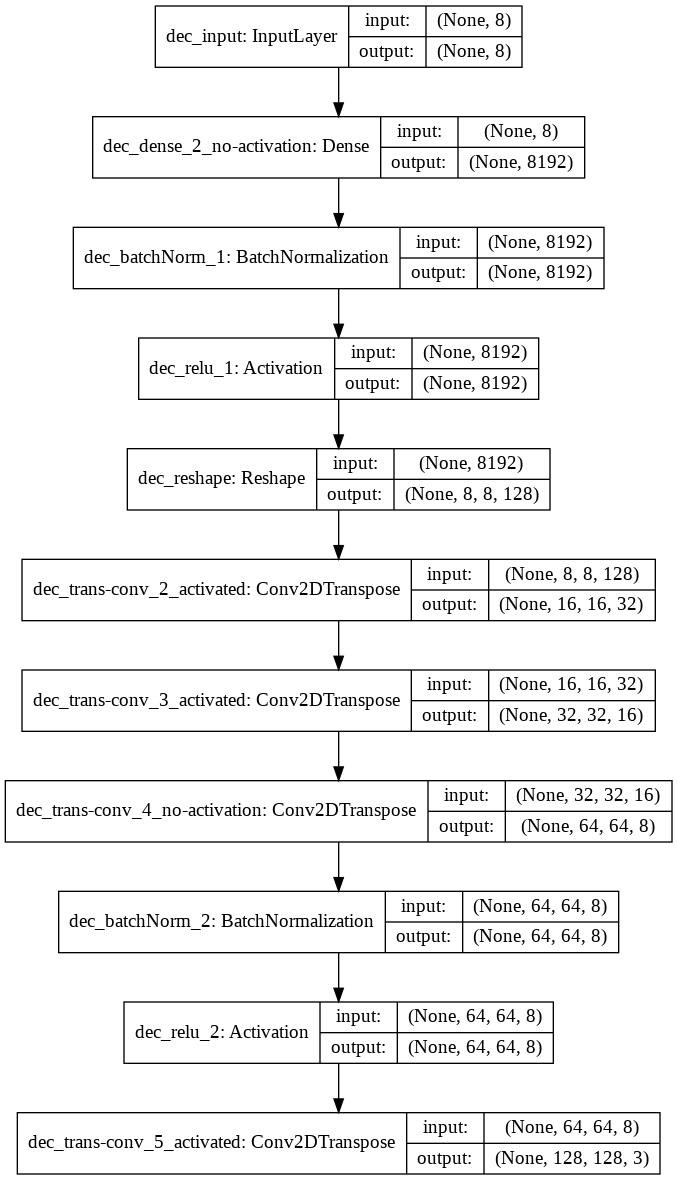

In [25]:
summarize(decoder_1)

### Decoder 2

In [26]:
# VAE decoder 2 - inception units
input_dec = Input(shape=(dec_dim,), name="dec_input")
h_d = Dense(dim_post_flatten, name="dec_dense_2_no-activation")(input_dec)
h_d = BatchNormalization(name="dec_batchNorm_1")(h_d)
h_d = Activation(activation="relu", name="dec_relu_1")(h_d)
h_d = Reshape(dim_pre_flatten,name="dec_reshape")(h_d)

## inception 1
inc1_1 = Conv2D(filters= 16, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc1_2 = Conv2D(filters= 16, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc1_1,inc1_2])

h_d = Conv2DTranspose(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_2_activated")(h_d)

## inception 2
inc2_1 = Conv2D(filters= 8, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc2_2 = Conv2D(filters= 8, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc2_1,inc2_2])

h_d = Conv2DTranspose(filters= 16, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_3_activated")(h_d)

## inception 3
inc3_1 = Conv2D(filters= 4, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc3_2 = Conv2D(filters= 4, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc3_1,inc3_2])

h_d = Conv2DTranspose(filters= 8, kernel_size=3, strides=2, padding='same', name="dec_trans-conv_4_no-activation")(h_d)
h_d = BatchNormalization(name="dec_batchNorm_2")(h_d)
h_d = Activation(activation="relu", name="dec_relu_2")(h_d)

## inception 4
inc4_1 = Conv2D(filters= 2, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc4_2 = Conv2D(filters= 2, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc4_1,inc4_2])

h_d = Conv2DTranspose(filters= colors, kernel_size=3, strides=2, padding='same', activation="sigmoid", name="dec_trans-conv_5_activated")(h_d) # the activation depends on the data normalization (sigmoid or tanh)

decoder_2 = Model(inputs=input_dec, outputs = h_d, name="decoder")

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_input (InputLayer)          (None, 8)            0                                            
__________________________________________________________________________________________________
dec_dense_2_no-activation (Dens (None, 8192)         73728       dec_input[0][0]                  
__________________________________________________________________________________________________
dec_batchNorm_1 (BatchNormaliza (None, 8192)         32768       dec_dense_2_no-activation[0][0]  
__________________________________________________________________________________________________
dec_relu_1 (Activation)         (None, 8192)         0           dec_batchNorm_1[0][0]            
____________________________________________________________________________________________

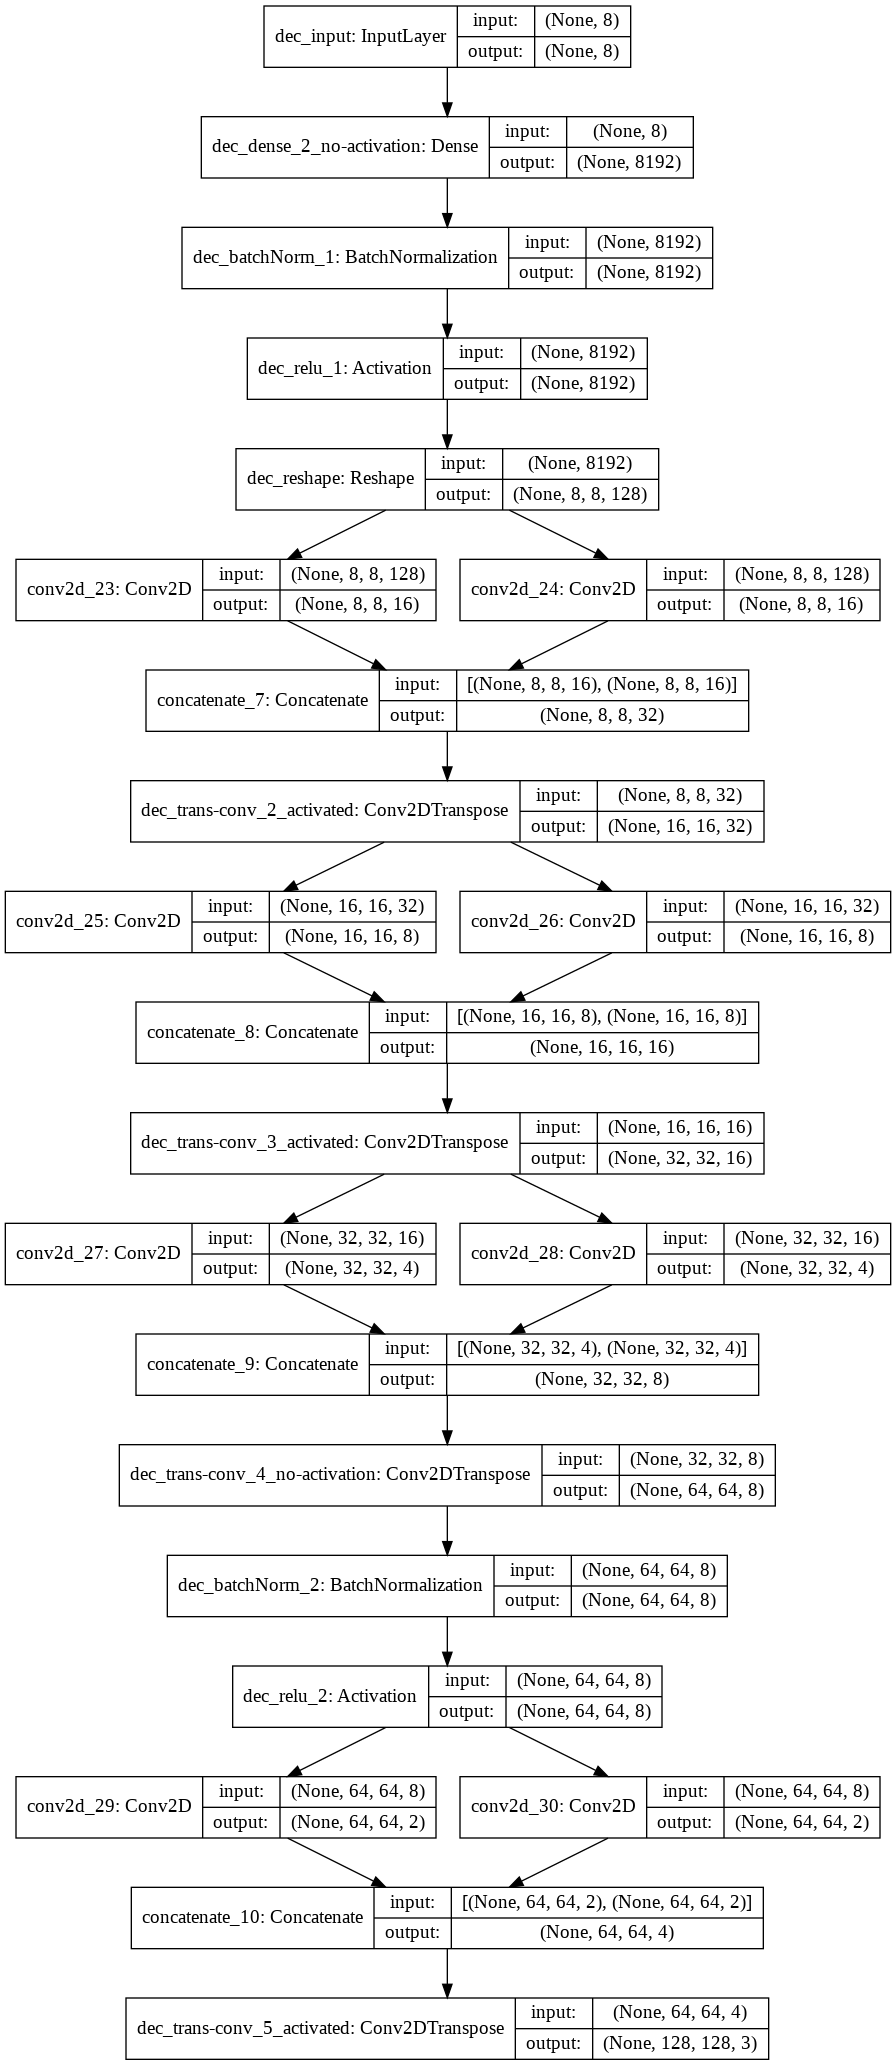

In [27]:
summarize(decoder_2)

### Decoder 3

In [28]:
# decoder 3 - Generator
noise = Input(shape=(dec_dim,), name="G_in")
# Dense 1
h = Dense(1024)(noise) 
h = BatchNormalization(momentum=0.99)(h) #0.8
h = Activation("relu")(h)
# Dense 2
h = Dense(7*7*128)(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Reshape
h = Reshape((7, 7, 128))(h)
# Conv 1
h = Conv2DTranspose(64, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv 2
h = Conv2DTranspose(32, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv to image
h = Conv2DTranspose(colors, kernel_size=1, strides=1, padding="same")(h)
G_out = Activation("sigmoid", name="G_out")(h)
decoder_3 = Model(noise,G_out,name="decoder")

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
G_in (InputLayer)            (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              9216      
_________________________________________________________________
batch_normalization_15 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_16 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_2 (Activation)    (None, 6272)              0   

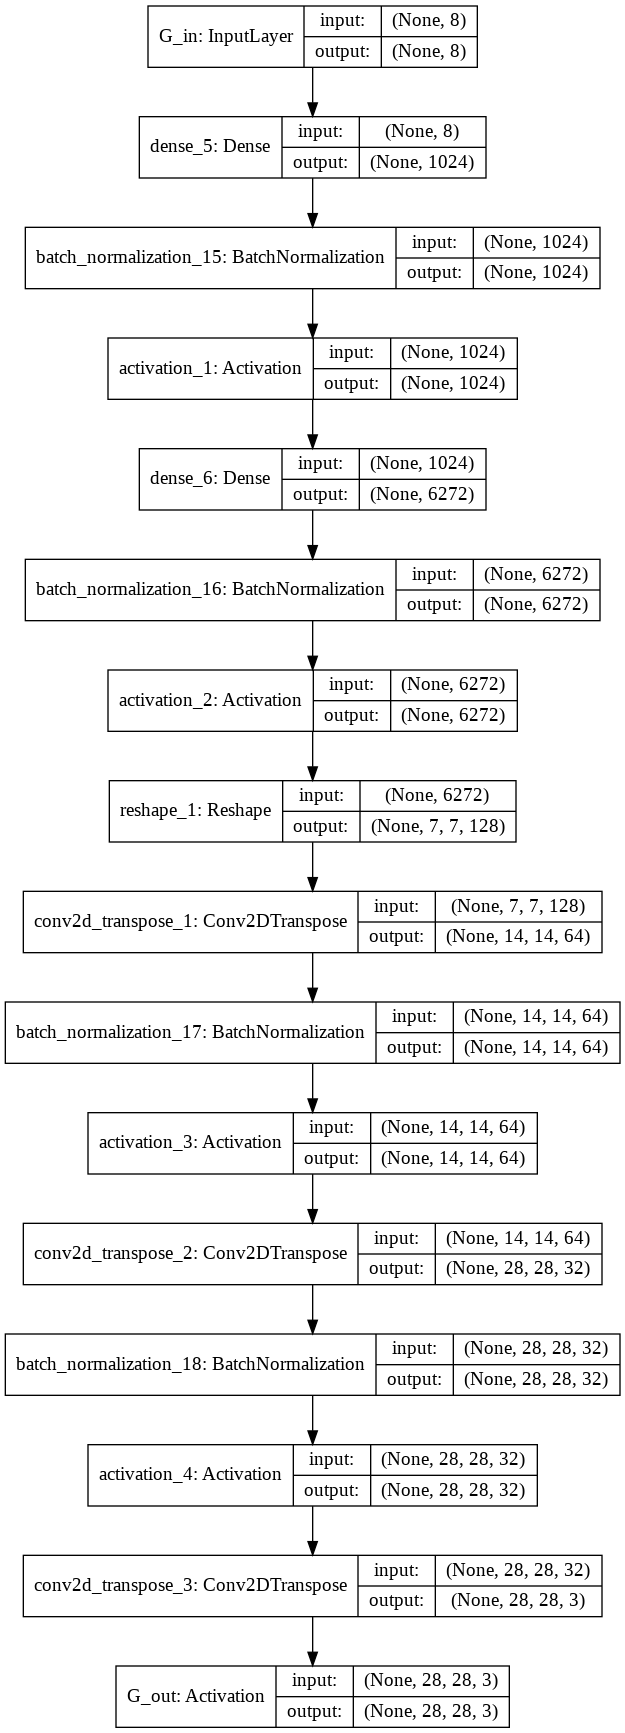

In [29]:
summarize(decoder_3)

### Decoder 4

In [30]:
# decoder 4 - Generator
noise = Input(shape=(dec_dim,), name="G_in")
## add labels
input_dec_labels = Input(shape=(labels_dim,), name="dec_input_labels")
h = concatenate([noise,input_dec_labels])
# Dense 1
h = Dense(1024)(h) 
h = BatchNormalization(momentum=0.99)(h) #0.8
h = Activation("relu")(h)
# Dense 2
h = Dense(dim_post_flatten)(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Reshape
h = Reshape(dim_pre_flatten)(h)
# Conv 1
h = Conv2DTranspose(64, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv 2
h = Conv2DTranspose(32, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv 3
h = Conv2DTranspose(16, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv to image
h = Conv2DTranspose(colors, kernel_size=1, strides=1, padding="same")(h)
G_out = Activation("sigmoid", name="G_out")(h)
decoder_4 = Model([noise,input_dec_labels],G_out,name="decoder")

### Summary

In [31]:
decoder = decoder_4

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
G_in (InputLayer)               (None, 8)            0                                            
__________________________________________________________________________________________________
dec_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 11)           0           G_in[0][0]                       
                                                                 dec_input_labels[0][0]           
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1024)         12288       concatenate_11[0][0]       

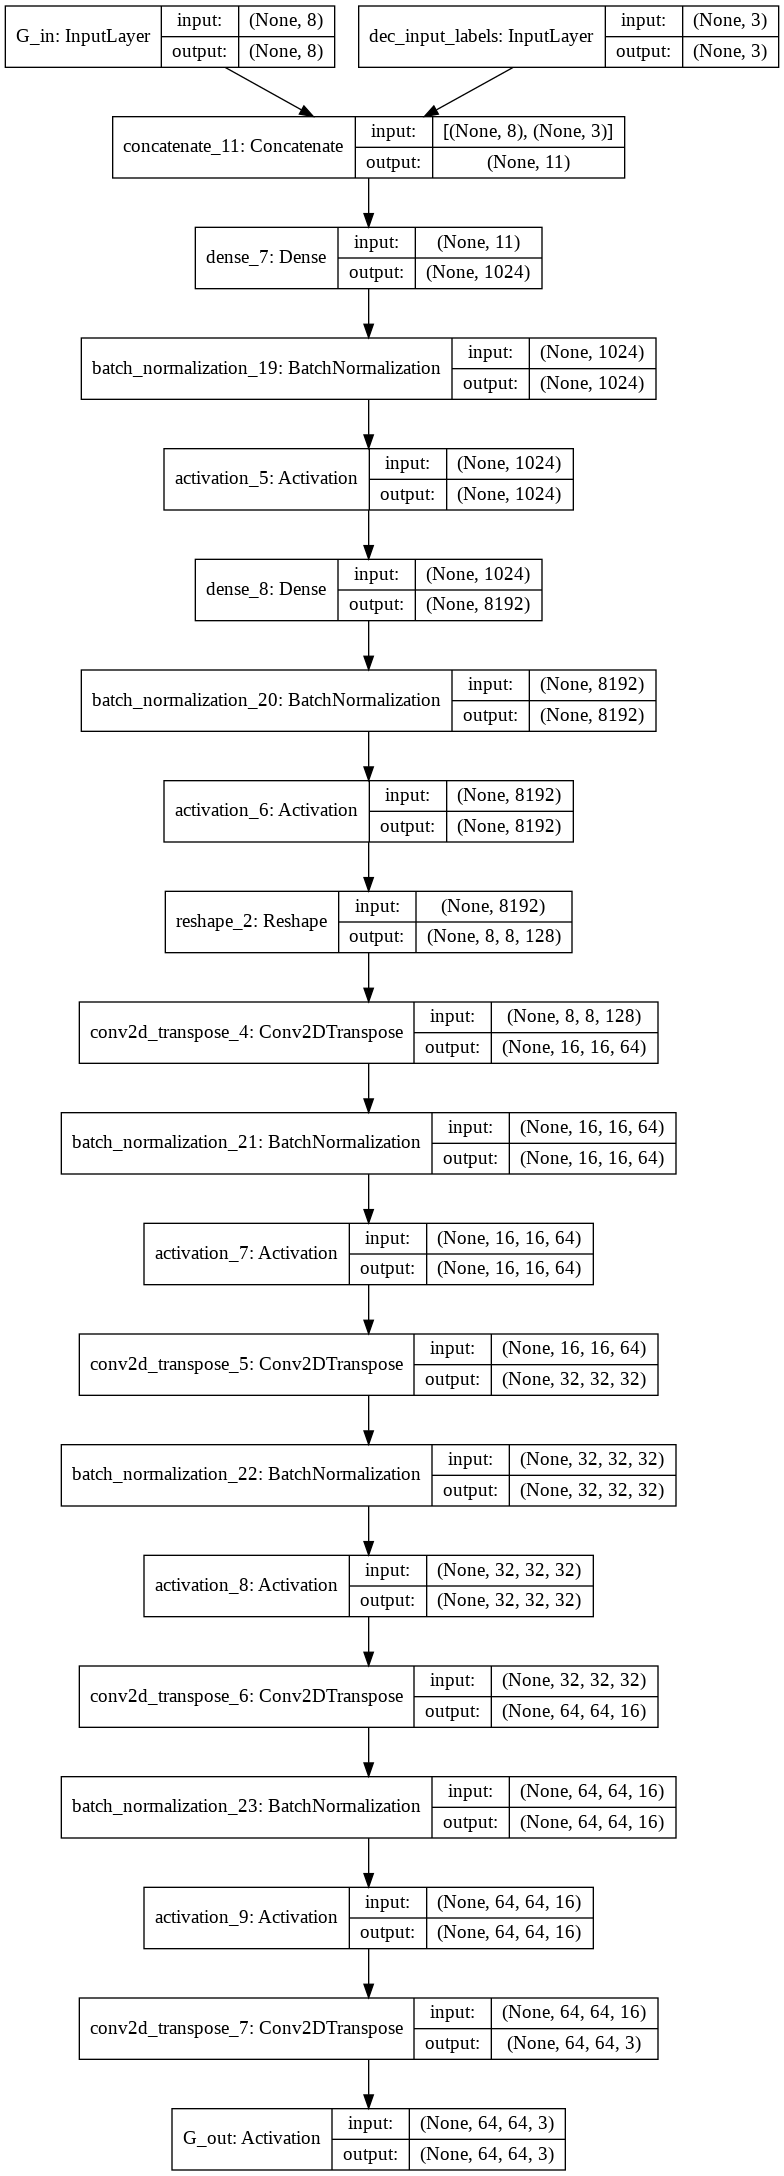

In [32]:
# summary of the decoder
decoder.summary()
# plot model
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='decoder.png')

# Sampler

In [33]:
# sampling function
def gaussian_sampling(tensors):
    mu, sigma = tensors
    #batch_shape = mu.shape # this way does not work to extract shape of tensor
    # two ways to exrtact tensor shape
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    return sigma*K.random_normal(shape=(batch, dim)) + mu
    #batch_shape = K.shape(mu)
    #return sigma*K.random_normal(shape=batch_shape) + mu

In [34]:
# sampling function
def gaussian_sampling_array(arrays):
    mu, sigma = arrays
    batch = mu.shape[0]
    dim = mu.shape[1]
    return sigma* np.random.normal(size=(batch, dim))+ mu
    #batch_shape = K.shape(mu)
    #return sigma*K.random_normal(shape=batch_shape) + mu

# Pipelines

## VAE

In [35]:

# VAE encoder + decoder
input_vae = Input(shape=(img_dim,img_dim,colors,), name="vae_input")
input_vae_labels = Input(shape=(labels_dim,), name="vae_input_labels")
z_latent = encoder([input_vae,input_vae_labels])
if ALPHA:
  sampling_layer = Lambda(gaussian_sampling,name="sample_Gaussian")
  z_sample = sampling_layer(z_latent)
  output_vae = decoder([z_sample,input_vae_labels])
else:
  output_vae = decoder([z_latent,input_vae_labels])
VAE = Model(inputs=[input_vae,input_vae_labels], outputs = output_vae)
#VAE = Model(inputs=input_vae, outputs = [output_vae,output_vae]) # two outputs to track two losses


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vae_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
vae_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 8511152     vae_input[0][0]                  
                                                                 vae_input_labels[0][0]           
__________________________________________________________________________________________________
sample_Gaussian (Lambda)        (None, 8)            0           encoder[1][0]              

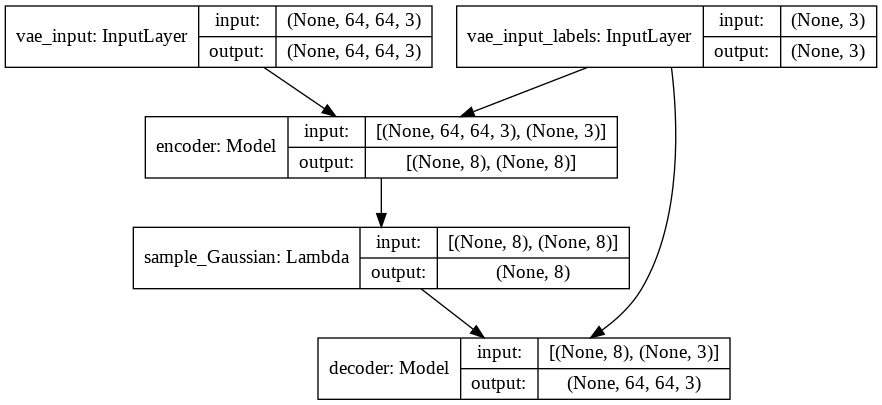

In [36]:
# summary of the complete VAE
VAE.summary()
# plot model
plot_model(VAE, to_file='VAE.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='VAE.png')

## Combined VAE-GAN

In [37]:
# Combined GAN: encoder + decoder + discriminator
input_GAN = Input(shape=(img_dim,img_dim,colors,), name="GAN_input")
input_GAN_labels = Input(shape=(labels_dim,), name="gan_input_labels")
z_latent = encoder([input_GAN,input_GAN_labels])
if ALPHA:
  sampling_layer = Lambda(gaussian_sampling,name="sample_Gaussian") 
  z_sample = sampling_layer(z_latent)
  output_vae = decoder([z_sample,input_GAN_labels])
else:
  output_vae = decoder([z_latent,input_GAN_labels])
          
# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
output_GAN = discriminator(output_vae)

# The combined model  (stacked generator and discriminator)
combined_GAN = Model([input_GAN,input_GAN_labels], output_GAN)

In [38]:
'''
# GAN only: decoder(generator) + discriminator
input_gen = Input(shape=(dec_dim,), name="gen_input")
input_gen_labels = Input(shape=(labels_dim,), name="gen_input_labels")
output_gen = decoder([input_gen,input_gen_labels])
          
# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
output_GAN_disc = discriminator(output_gen)

# The combined model  (stacked generator and discriminator)
GAN = Model([input_gen,input_gen_labels], output_GAN_disc)
'''

'\n# GAN only: decoder(generator) + discriminator\ninput_gen = Input(shape=(dec_dim,), name="gen_input")\ninput_gen_labels = Input(shape=(labels_dim,), name="gen_input_labels")\noutput_gen = decoder([input_gen,input_gen_labels])\n          \n# For the combined model we will only train the generator\ndiscriminator.trainable = False\n\n# The discriminator takes generated images as input and determines validity\noutput_GAN_disc = discriminator(output_gen)\n\n# The combined model  (stacked generator and discriminator)\nGAN = Model([input_gen,input_gen_labels], output_GAN_disc)\n'

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GAN_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
gan_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 8511152     GAN_input[0][0]                  
                                                                 gan_input_labels[0][0]           
__________________________________________________________________________________________________
sample_Gaussian (Lambda)        (None, 8)            0           encoder[2][0]              

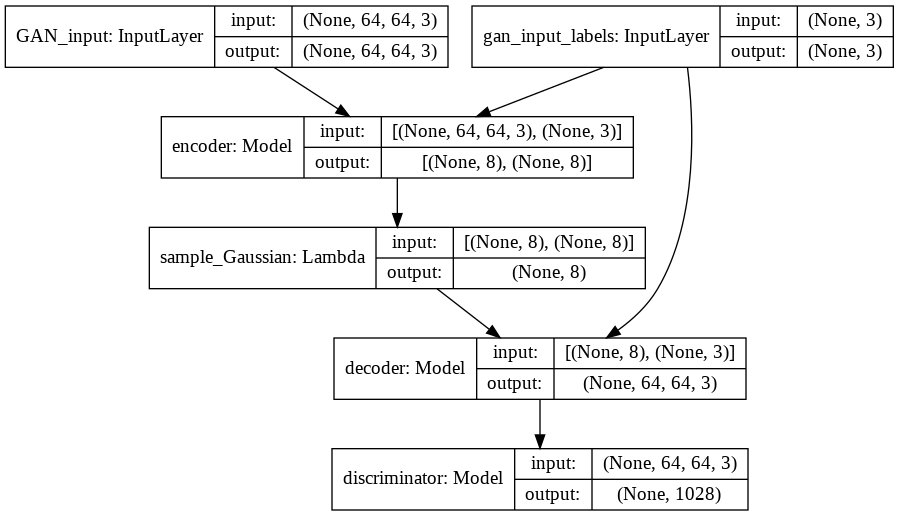

In [39]:
# summary of the combined GAN
combined_GAN.summary()
# plot model
plot_model(combined_GAN, to_file='combined_GAN.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='combined_GAN.png')

# Loss functions

In [40]:
## K = keras.Backend
## z_latent = [noise, labels]

# VAE loss
def my_vae_loss(y_true, y_pred):
    #reconstruction_loss = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= img_dim * img_dim

    if ALPHA:
      #kl_loss = 1 + 2*K.log(z_std) - K.square(z_mu) - K.square(z_std) # this does NOT work (need to use the names as in the VAE)
      kl_loss = 1 + 2*K.log(z_latent[1]) - K.square(z_latent[0]) - K.square(z_latent[1])
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      vae_loss = K.mean(reconstruction_loss + BETA*kl_loss)
    else:
      vae_loss = K.mean(reconstruction_loss)
    return vae_loss

def my_vae_loss_recon(y_true, y_pred):
    #reconstruction_loss = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))

    reconstruction_loss *= img_dim * img_dim
    vae_loss = K.mean(reconstruction_loss)
    return vae_loss

def my_vae_loss_kl(y_true, y_pred):
    kl_loss = 1 + 2*K.log(z_latent[1]) - K.square(z_latent[0]) - K.square(z_latent[1])
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(kl_loss)
    return vae_loss

In [41]:
# GAN loss with mse and labels and learned metric, one output
def my_GAN_loss(y_true, y_pred):
    ## true/false
    adv_loss = binary_crossentropy(y_true[:,0],y_pred[:,0])
    ## labels
    class_loss = categorical_crossentropy(y_true[:,1:1+labels_dim],y_pred[:,1:1+labels_dim])
    ## image reconstruction
    reconstruction_loss = img_dim * img_dim * mse(K.flatten(input_GAN), K.flatten(output_vae))
    ## features
    learned_metric = mse(y_true[:,1+labels_dim:],y_pred[:,1+labels_dim:])


    if ALPHA:
      #kl_loss = 1 + 2*K.log(z_std) - K.square(z_mu) - K.square(z_std) # this does NOT work (need to use the names as in the VAE)
      kl_loss = 1 + 2*K.log(z_latent[1]) - K.square(z_latent[0]) - K.square(z_latent[1])
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      GAN_loss = K.mean(adv_loss + ZETA*reconstruction_loss + BETA*kl_loss + DELTA*class_loss + GAMMA*learned_metric)
    else:
      GAN_loss = K.mean(adv_loss + ZETA*reconstruction_loss + DELTA*class_loss + GAMMA*learned_metric)
    return GAN_loss

In [42]:
# discriminator loss with labels, one output
def my_disc_loss(y_true, y_pred):
    adv_loss = binary_crossentropy(y_true[:,0],y_pred[:,0])
    class_loss = categorical_crossentropy(y_true[:,1:1+labels_dim],y_pred[:,1:1+labels_dim])
    disc_loss = K.mean(adv_loss + DELTA*class_loss)
    return disc_loss

# Compile

In [43]:

#VAE.compile(Adam(lr=0.02), loss=my_vae_loss)
#VAE.compile(Adam(), loss=my_vae_loss)
VAE.compile(optimizer = optimizer, loss=my_vae_loss)

#VAE.compile(Adam(lr=0.02), loss = [my_vae_loss_recon,my_vae_loss_kl], loss_weights = [1,BETA]) # two losses


In [44]:
combined_GAN.compile(optimizer = optimizer, loss=my_GAN_loss)

In [45]:
'''
GAN.compile(optimizer = optimizer, loss='binary_crossentropy')
'''

"\nGAN.compile(optimizer = optimizer, loss='binary_crossentropy')\n"

In [46]:
# compile discriminator with labels, one ouput
# second method, compile discriminator here after compiling combined GAN model and resetting trainable to true
discriminator.trainable = True
discriminator.compile(loss= my_disc_loss, optimizer= optimizer)

In [47]:
combined_GAN.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GAN_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
gan_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 8511152     GAN_input[0][0]                  
                                                                 gan_input_labels[0][0]           
__________________________________________________________________________________________________
sample_Gaussian (Lambda)        (None, 8)            0           encoder[2][0]              

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [48]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
D_in (InputLayer)               (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
discriminator_metric (Model)    (None, 1024)         8491680     D_in[0][0]                       
__________________________________________________________________________________________________
D_out_adv (Dense)               (None, 1)            1025        discriminator_metric[1][0]       
__________________________________________________________________________________________________
D_out_labels (Dense)            (None, 3)            3075        discriminator_metric[1][0]       
______________________________________________________________________________________

# Dataset

In [49]:
# Mount google drive in the virtual machine
from google.colab import drive
drive.mount('/drive')


Mounted at /drive


In [50]:
x_train = np.load(root + 'galaxyzoo_data_cropped_nonnormalized.npy')
x_train = x_train/255.0

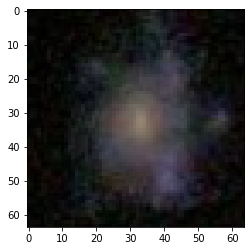

In [51]:
plt.imshow(x_train[8])

In [52]:
x_train.shape

(61578, 64, 64, 3)

In [53]:
import pandas as pd
df =  pd.read_csv(root + 'training_solutions_rev1.csv')
labels_train = np.array(df[df.columns[1:4]])

In [54]:
labels_train.shape

(61578, 3)

# Training

In [55]:
epochs=20
batch_size=128
save_interval=200
      
d_costs = []
g_costs = []

N = len(x_train)
n_batches = N // batch_size
total_iter = 0

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# make dir to save My_samples
if not os.path.exists(root_output):
  os.mkdir(root_output)

In [56]:
def save_imgs(iteration,gen_imgs):
        r, c = 8, 8
        #noise = np.random.normal(0, 1, (r * c, latent_dim))
        #gen_imgs = decoder.predict(noise)
        
        
        d = img_dim
        
        if gen_imgs.shape[-1] == 1:
            # if color == 1, we want a 2-D image (N x N)
            gen_imgs = gen_imgs.reshape(r*c, d, d)
            flat_image = np.empty((r*d, c*d))

            k = 0
            for i in range(8):
              for j in range(8):
                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = gen_imgs[k].reshape(d, d)
                k += 1

            
        else:
          # if color == 3, we want a 3-D image (N x N x 3)
          flat_image = np.empty((r*d, c*d, 3))
          k = 0
          for i in range(8):
            for j in range(8):
              flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = gen_imgs[k]
              #flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = (gen_imgs[k]+1)/2 # MD (not necessary, the png or jpg preview visualize both ranges the same way)
              k += 1
            
            
        # plt.savefig('samples/samples_at_iter_%d.png' % total_iters)
        #sp.misc.imsave('/content/drive/My Drive/Colab/VAE/images/samples_at_iter_%d.png' % iteration,flat_image)
        imageio.imwrite(root_output + f'samples_at_iter_{iteration}.png', flat_image)

In [57]:
# train GAN or combined GAN
for epoch in range(epochs):
        
      print("epoch:", epoch+1)
      #np.random.shuffle(x_train)
      idx = np.random.permutation(len(x_train))
      x_train = x_train[idx]
      labels_train = labels_train[idx]
        
      for j in range(n_batches):
        t0 = datetime.now()
      
      

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a batch of images
        imgs = x_train[j*batch_size:(j+1)*batch_size]

        labels = labels_train[j*batch_size:(j+1)*batch_size]
      
        # Sample noise and generate a batch of new images
        #noise = np.random.normal(0, 1, (batch_size, latent_dim))
        #gen_imgs = decoder.predict(noise)

        #noise_latent = encoder.predict(imgs)
        #if ALPHA:
          #gen_imgs = decoder.predict(gaussian_sampling_array(noise_latent))
        #else:
          #gen_imgs = decoder.predict(noise_latent)

        gen_imgs = VAE.predict([imgs,labels])
          

        # Train the discriminator (real classified as ones and generated as zeros)
        #d_loss_real = discriminator.train_on_batch(imgs, [valid,labels])
        #d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake,labels])
        d_loss_real = discriminator.train_on_batch(imgs, np.concatenate((valid,labels),axis=1))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.concatenate((fake,labels),axis=1))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        #d_loss = np.add(d_loss_real, d_loss_fake)
          
        d_costs.append(d_loss)
          

        # ---------------------
        #  Train Generator
        # ---------------------

        metric_real = discriminator_metric.predict(imgs)

        # Train the generator (wants discriminator to mistake images as real)
        #g_loss = combined_GAN.train_on_batch([imgs,labels], [valid,labels])
        g_loss = combined_GAN.train_on_batch([imgs,labels], np.concatenate((valid,labels,metric_real),axis=1))


        #g_loss = GAN.train_on_batch(noise, valid)
          
        g_costs.append(g_loss)

        # Plot the progress
        #print ("Epoch %d - Batch: %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f] dt: %s " % (epoch+1,j+1,n_batches, d_loss[0], 100*d_loss[1], g_loss[0],datetime.now() - t0))
        print ("Epoch %d - Batch: %d/%d [D loss: %f] [G loss: %f] dt: %s " % (epoch+1,j+1,n_batches, d_loss, g_loss,datetime.now() - t0))
        total_iter += 1        
        # If at save interval => save generated image samples
        if total_iter  % save_interval == 0:
          save_imgs(total_iter,gen_imgs[:64])

# save a plot of the costs
plt.clf()
plt.plot(d_costs, label='discriminator cost')
plt.plot(g_costs, label='generator cost')
plt.legend()
plt.savefig(root_output + 'cost_vs_iteration.png')
plt.close()

# save models
#combined_GAN.save('/content/drive/My Drive/Colab/VAE/images_GAN/combined_GAN_model')
#VAE.save('/content/drive/My Drive/Colab/VAE/images_GAN/VAE_model')
#GAN.save('/content/drive/My Drive/Colab/VAE/images_GAN/GAN_model')

epoch: 1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 - Batch: 1/481 [D loss: 1.964995] [G loss: 817.041992] dt: 0:00:16.826236 
Epoch 1 - Batch: 2/481 [D loss: 3.017991] [G loss: 817.214111] dt: 0:00:00.142634 


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 - Batch: 3/481 [D loss: 2.503012] [G loss: 794.990051] dt: 0:00:00.134391 
Epoch 1 - Batch: 4/481 [D loss: 1.870455] [G loss: 774.199280] dt: 0:00:00.133067 
Epoch 1 - Batch: 5/481 [D loss: 1.740686] [G loss: 756.994141] dt: 0:00:00.136312 
Epoch 1 - Batch: 6/481 [D loss: 1.921704] [G loss: 732.678284] dt: 0:00:00.130823 
Epoch 1 - Batch: 7/481 [D loss: 1.982226] [G loss: 696.667480] dt: 0:00:00.132127 
Epoch 1 - Batch: 8/481 [D loss: 1.569197] [G loss: 677.377808] dt: 0:00:00.128965 
Epoch 1 - Batch: 9/481 [D loss: 1.434028] [G loss: 665.831909] dt: 0:00:00.130211 
Epoch 1 - Batch: 10/481 [D loss: 1.391550] [G loss: 613.082031] dt: 0:00:00.127974 
Epoch 1 - Batch: 11/481 [D loss: 1.340487] [G loss: 583.589172] dt: 0:00:00.130636 
Epoch 1 - Batch: 12/481 [D loss: 1.526756] [G loss: 565.874390] dt: 0:00:00.132935 
Epoch 1 - Batch: 13/481 [D loss: 1.504735] [G loss: 564.321228] dt: 0:00:00.134273 
Epoch 1 - Batch: 14/481 [D loss: 1.156437] [G loss: 518.694397] dt: 0:00:00.133793 

Epoch 1 - Batch: 201/481 [D loss: 0.768411] [G loss: 1245.292969] dt: 0:00:00.137840 
Epoch 1 - Batch: 202/481 [D loss: 1.401023] [G loss: 1111.106934] dt: 0:00:00.131261 
Epoch 1 - Batch: 203/481 [D loss: 1.680087] [G loss: 1027.874512] dt: 0:00:00.134422 
Epoch 1 - Batch: 204/481 [D loss: 0.890164] [G loss: 1086.989502] dt: 0:00:00.129442 
Epoch 1 - Batch: 205/481 [D loss: 0.899163] [G loss: 982.531982] dt: 0:00:00.134646 
Epoch 1 - Batch: 206/481 [D loss: 0.892937] [G loss: 895.302917] dt: 0:00:00.128459 
Epoch 1 - Batch: 207/481 [D loss: 0.978207] [G loss: 873.502930] dt: 0:00:00.137083 
Epoch 1 - Batch: 208/481 [D loss: 1.034389] [G loss: 944.545349] dt: 0:00:00.133079 
Epoch 1 - Batch: 209/481 [D loss: 0.793633] [G loss: 878.481567] dt: 0:00:00.135875 
Epoch 1 - Batch: 210/481 [D loss: 0.815341] [G loss: 945.780090] dt: 0:00:00.128825 
Epoch 1 - Batch: 211/481 [D loss: 0.710421] [G loss: 972.398438] dt: 0:00:00.131142 
Epoch 1 - Batch: 212/481 [D loss: 0.775268] [G loss: 893.9422

Epoch 1 - Batch: 401/481 [D loss: 1.090389] [G loss: 793.612915] dt: 0:00:00.134993 
Epoch 1 - Batch: 402/481 [D loss: 1.002720] [G loss: 781.823608] dt: 0:00:00.128764 
Epoch 1 - Batch: 403/481 [D loss: 1.012560] [G loss: 698.577393] dt: 0:00:00.131001 
Epoch 1 - Batch: 404/481 [D loss: 1.073744] [G loss: 956.389893] dt: 0:00:00.129737 
Epoch 1 - Batch: 405/481 [D loss: 1.123246] [G loss: 720.555176] dt: 0:00:00.133796 
Epoch 1 - Batch: 406/481 [D loss: 1.252834] [G loss: 779.815247] dt: 0:00:00.131423 
Epoch 1 - Batch: 407/481 [D loss: 1.107930] [G loss: 847.958618] dt: 0:00:00.135985 
Epoch 1 - Batch: 408/481 [D loss: 0.968498] [G loss: 905.612305] dt: 0:00:00.133885 
Epoch 1 - Batch: 409/481 [D loss: 0.973722] [G loss: 981.401489] dt: 0:00:00.133041 
Epoch 1 - Batch: 410/481 [D loss: 1.045410] [G loss: 808.636719] dt: 0:00:00.128513 
Epoch 1 - Batch: 411/481 [D loss: 1.133900] [G loss: 805.272644] dt: 0:00:00.130840 
Epoch 1 - Batch: 412/481 [D loss: 1.228691] [G loss: 860.548279] 

Epoch 2 - Batch: 120/481 [D loss: 1.045516] [G loss: 2535.281250] dt: 0:00:00.133370 
Epoch 2 - Batch: 121/481 [D loss: 1.070897] [G loss: 2511.428223] dt: 0:00:00.128301 
Epoch 2 - Batch: 122/481 [D loss: 0.998699] [G loss: 2652.628418] dt: 0:00:00.133231 
Epoch 2 - Batch: 123/481 [D loss: 0.894038] [G loss: 2927.881104] dt: 0:00:00.127213 
Epoch 2 - Batch: 124/481 [D loss: 1.169962] [G loss: 3285.617188] dt: 0:00:00.128848 
Epoch 2 - Batch: 125/481 [D loss: 1.497622] [G loss: 2634.401611] dt: 0:00:00.129447 
Epoch 2 - Batch: 126/481 [D loss: 1.296567] [G loss: 2580.074707] dt: 0:00:00.129074 
Epoch 2 - Batch: 127/481 [D loss: 1.016532] [G loss: 2817.957031] dt: 0:00:00.133756 
Epoch 2 - Batch: 128/481 [D loss: 1.031014] [G loss: 2602.698730] dt: 0:00:00.132717 
Epoch 2 - Batch: 129/481 [D loss: 0.988785] [G loss: 2554.527832] dt: 0:00:00.127870 
Epoch 2 - Batch: 130/481 [D loss: 0.966685] [G loss: 2240.593750] dt: 0:00:00.133607 
Epoch 2 - Batch: 131/481 [D loss: 1.049817] [G loss: 2

Epoch 2 - Batch: 320/481 [D loss: 0.881196] [G loss: 688.255127] dt: 0:00:00.132707 
Epoch 2 - Batch: 321/481 [D loss: 0.845879] [G loss: 697.607849] dt: 0:00:00.129859 
Epoch 2 - Batch: 322/481 [D loss: 0.857365] [G loss: 751.338013] dt: 0:00:00.130617 
Epoch 2 - Batch: 323/481 [D loss: 0.821938] [G loss: 764.900757] dt: 0:00:00.129255 
Epoch 2 - Batch: 324/481 [D loss: 0.891873] [G loss: 1119.036377] dt: 0:00:00.134541 
Epoch 2 - Batch: 325/481 [D loss: 0.884833] [G loss: 1255.445312] dt: 0:00:00.132041 
Epoch 2 - Batch: 326/481 [D loss: 0.796705] [G loss: 1272.359741] dt: 0:00:00.131734 
Epoch 2 - Batch: 327/481 [D loss: 0.977212] [G loss: 1290.169067] dt: 0:00:00.132408 
Epoch 2 - Batch: 328/481 [D loss: 0.911661] [G loss: 1356.986084] dt: 0:00:00.133515 
Epoch 2 - Batch: 329/481 [D loss: 0.844087] [G loss: 1438.951172] dt: 0:00:00.131923 
Epoch 2 - Batch: 330/481 [D loss: 0.941956] [G loss: 1505.419800] dt: 0:00:00.131339 
Epoch 2 - Batch: 331/481 [D loss: 0.939309] [G loss: 1547.

Epoch 3 - Batch: 39/481 [D loss: 1.207322] [G loss: 608.018982] dt: 0:00:00.131621 
Epoch 3 - Batch: 40/481 [D loss: 1.208760] [G loss: 594.580688] dt: 0:00:00.130852 
Epoch 3 - Batch: 41/481 [D loss: 1.433878] [G loss: 1545.088623] dt: 0:00:00.131520 
Epoch 3 - Batch: 42/481 [D loss: 1.208384] [G loss: 698.231140] dt: 0:00:00.132171 
Epoch 3 - Batch: 43/481 [D loss: 1.213044] [G loss: 690.591675] dt: 0:00:00.135845 
Epoch 3 - Batch: 44/481 [D loss: 1.260718] [G loss: 674.056824] dt: 0:00:00.131882 
Epoch 3 - Batch: 45/481 [D loss: 1.165069] [G loss: 720.644287] dt: 0:00:00.133979 
Epoch 3 - Batch: 46/481 [D loss: 1.229760] [G loss: 732.573120] dt: 0:00:00.131293 
Epoch 3 - Batch: 47/481 [D loss: 1.059772] [G loss: 679.128174] dt: 0:00:00.138025 
Epoch 3 - Batch: 48/481 [D loss: 1.114521] [G loss: 833.664490] dt: 0:00:00.128318 
Epoch 3 - Batch: 49/481 [D loss: 0.959561] [G loss: 772.912598] dt: 0:00:00.135733 
Epoch 3 - Batch: 50/481 [D loss: 1.039866] [G loss: 732.640137] dt: 0:00:00

Epoch 3 - Batch: 239/481 [D loss: 0.866038] [G loss: 1319.864258] dt: 0:00:00.133533 
Epoch 3 - Batch: 240/481 [D loss: 0.846017] [G loss: 1298.572510] dt: 0:00:00.130523 
Epoch 3 - Batch: 241/481 [D loss: 1.039112] [G loss: 1492.537598] dt: 0:00:00.130896 
Epoch 3 - Batch: 242/481 [D loss: 1.083671] [G loss: 1304.847900] dt: 0:00:00.128469 
Epoch 3 - Batch: 243/481 [D loss: 1.209050] [G loss: 1148.617065] dt: 0:00:00.131081 
Epoch 3 - Batch: 244/481 [D loss: 1.061203] [G loss: 996.773804] dt: 0:00:00.136846 
Epoch 3 - Batch: 245/481 [D loss: 1.022826] [G loss: 946.483215] dt: 0:00:00.131118 
Epoch 3 - Batch: 246/481 [D loss: 0.959020] [G loss: 1065.201294] dt: 0:00:00.128623 
Epoch 3 - Batch: 247/481 [D loss: 0.968240] [G loss: 1257.505127] dt: 0:00:00.131925 
Epoch 3 - Batch: 248/481 [D loss: 0.937860] [G loss: 1377.903076] dt: 0:00:00.135238 
Epoch 3 - Batch: 249/481 [D loss: 1.033715] [G loss: 1290.664917] dt: 0:00:00.132552 
Epoch 3 - Batch: 250/481 [D loss: 1.321992] [G loss: 146

Epoch 3 - Batch: 439/481 [D loss: 1.065526] [G loss: 1422.911621] dt: 0:00:00.133487 
Epoch 3 - Batch: 440/481 [D loss: 1.098062] [G loss: 1899.910156] dt: 0:00:00.132869 
Epoch 3 - Batch: 441/481 [D loss: 1.031624] [G loss: 1653.523438] dt: 0:00:00.131218 
Epoch 3 - Batch: 442/481 [D loss: 0.943695] [G loss: 1690.145020] dt: 0:00:00.130854 
Epoch 3 - Batch: 443/481 [D loss: 1.065939] [G loss: 1720.521118] dt: 0:00:00.133852 
Epoch 3 - Batch: 444/481 [D loss: 1.083517] [G loss: 2049.670166] dt: 0:00:00.133614 
Epoch 3 - Batch: 445/481 [D loss: 1.142932] [G loss: 2064.891113] dt: 0:00:00.134775 
Epoch 3 - Batch: 446/481 [D loss: 0.942157] [G loss: 1982.059448] dt: 0:00:00.133590 
Epoch 3 - Batch: 447/481 [D loss: 0.955245] [G loss: 1946.420410] dt: 0:00:00.134670 
Epoch 3 - Batch: 448/481 [D loss: 1.055938] [G loss: 1808.175537] dt: 0:00:00.132783 
Epoch 3 - Batch: 449/481 [D loss: 0.995788] [G loss: 1714.479248] dt: 0:00:00.135492 
Epoch 3 - Batch: 450/481 [D loss: 1.311074] [G loss: 1

Epoch 4 - Batch: 158/481 [D loss: 0.806623] [G loss: 492.270996] dt: 0:00:00.136631 
Epoch 4 - Batch: 159/481 [D loss: 0.825080] [G loss: 494.437500] dt: 0:00:00.132094 
Epoch 4 - Batch: 160/481 [D loss: 0.772516] [G loss: 487.955597] dt: 0:00:00.134033 
Epoch 4 - Batch: 161/481 [D loss: 0.743330] [G loss: 532.862244] dt: 0:00:00.133121 
Epoch 4 - Batch: 162/481 [D loss: 0.749364] [G loss: 636.498657] dt: 0:00:00.133504 
Epoch 4 - Batch: 163/481 [D loss: 0.766709] [G loss: 984.595703] dt: 0:00:00.130430 
Epoch 4 - Batch: 164/481 [D loss: 1.221745] [G loss: 983.480713] dt: 0:00:00.138500 
Epoch 4 - Batch: 165/481 [D loss: 0.991241] [G loss: 1798.835327] dt: 0:00:00.133512 
Epoch 4 - Batch: 166/481 [D loss: 1.062189] [G loss: 1695.510986] dt: 0:00:00.132449 
Epoch 4 - Batch: 167/481 [D loss: 1.010564] [G loss: 1755.783813] dt: 0:00:00.133115 
Epoch 4 - Batch: 168/481 [D loss: 1.065050] [G loss: 1677.052246] dt: 0:00:00.132155 
Epoch 4 - Batch: 169/481 [D loss: 1.018986] [G loss: 2185.027

Epoch 4 - Batch: 358/481 [D loss: 0.981875] [G loss: 966.791077] dt: 0:00:00.130664 
Epoch 4 - Batch: 359/481 [D loss: 0.985289] [G loss: 1171.737061] dt: 0:00:00.131223 
Epoch 4 - Batch: 360/481 [D loss: 1.198028] [G loss: 1439.536377] dt: 0:00:00.132687 
Epoch 4 - Batch: 361/481 [D loss: 1.363759] [G loss: 1452.892700] dt: 0:00:00.127994 
Epoch 4 - Batch: 362/481 [D loss: 0.904099] [G loss: 1434.823242] dt: 0:00:00.133253 
Epoch 4 - Batch: 363/481 [D loss: 0.890198] [G loss: 1390.296387] dt: 0:00:00.128181 
Epoch 4 - Batch: 364/481 [D loss: 0.913828] [G loss: 1218.343384] dt: 0:00:00.130260 
Epoch 4 - Batch: 365/481 [D loss: 0.798341] [G loss: 1256.155151] dt: 0:00:00.128165 
Epoch 4 - Batch: 366/481 [D loss: 0.842299] [G loss: 1176.112305] dt: 0:00:00.130212 
Epoch 4 - Batch: 367/481 [D loss: 0.915212] [G loss: 1137.848145] dt: 0:00:00.130600 
Epoch 4 - Batch: 368/481 [D loss: 0.789819] [G loss: 1070.125977] dt: 0:00:00.128878 
Epoch 4 - Batch: 369/481 [D loss: 0.813049] [G loss: 10

Epoch 5 - Batch: 77/481 [D loss: 0.846662] [G loss: 1338.401611] dt: 0:00:00.130470 
Epoch 5 - Batch: 78/481 [D loss: 0.857168] [G loss: 1292.824219] dt: 0:00:00.128502 
Epoch 5 - Batch: 79/481 [D loss: 0.826994] [G loss: 1251.210083] dt: 0:00:00.132290 
Epoch 5 - Batch: 80/481 [D loss: 0.836241] [G loss: 1213.172852] dt: 0:00:00.128201 
Epoch 5 - Batch: 81/481 [D loss: 0.859313] [G loss: 1208.239624] dt: 0:00:00.135004 
Epoch 5 - Batch: 82/481 [D loss: 0.870830] [G loss: 1191.667480] dt: 0:00:00.132238 
Epoch 5 - Batch: 83/481 [D loss: 0.785659] [G loss: 1603.819824] dt: 0:00:00.135255 
Epoch 5 - Batch: 84/481 [D loss: 0.952245] [G loss: 1169.633301] dt: 0:00:00.128780 
Epoch 5 - Batch: 85/481 [D loss: 0.957564] [G loss: 1264.635742] dt: 0:00:00.135067 
Epoch 5 - Batch: 86/481 [D loss: 0.960931] [G loss: 1175.546631] dt: 0:00:00.130005 
Epoch 5 - Batch: 87/481 [D loss: 0.975011] [G loss: 1217.202515] dt: 0:00:00.131012 
Epoch 5 - Batch: 88/481 [D loss: 1.108617] [G loss: 1605.874268] 

Epoch 5 - Batch: 277/481 [D loss: 0.872925] [G loss: 827.142212] dt: 0:00:00.135678 
Epoch 5 - Batch: 278/481 [D loss: 0.836771] [G loss: 887.076477] dt: 0:00:00.131477 
Epoch 5 - Batch: 279/481 [D loss: 0.829778] [G loss: 974.635925] dt: 0:00:00.131928 
Epoch 5 - Batch: 280/481 [D loss: 1.044553] [G loss: 1032.479492] dt: 0:00:00.132540 
Epoch 5 - Batch: 281/481 [D loss: 0.906883] [G loss: 1011.941589] dt: 0:00:00.135800 
Epoch 5 - Batch: 282/481 [D loss: 0.872470] [G loss: 969.323975] dt: 0:00:00.129119 
Epoch 5 - Batch: 283/481 [D loss: 0.978222] [G loss: 1048.285645] dt: 0:00:00.134394 
Epoch 5 - Batch: 284/481 [D loss: 0.884561] [G loss: 1012.615784] dt: 0:00:00.130218 
Epoch 5 - Batch: 285/481 [D loss: 0.923913] [G loss: 1037.805786] dt: 0:00:00.134012 
Epoch 5 - Batch: 286/481 [D loss: 0.814323] [G loss: 919.259216] dt: 0:00:00.132200 
Epoch 5 - Batch: 287/481 [D loss: 0.889749] [G loss: 950.918945] dt: 0:00:00.130433 
Epoch 5 - Batch: 288/481 [D loss: 1.031183] [G loss: 964.785

Epoch 5 - Batch: 477/481 [D loss: 0.739848] [G loss: 554.495972] dt: 0:00:00.129670 
Epoch 5 - Batch: 478/481 [D loss: 0.737367] [G loss: 545.293274] dt: 0:00:00.127312 
Epoch 5 - Batch: 479/481 [D loss: 0.743566] [G loss: 549.740967] dt: 0:00:00.130830 
Epoch 5 - Batch: 480/481 [D loss: 1.150037] [G loss: 714.200439] dt: 0:00:00.128302 
Epoch 5 - Batch: 481/481 [D loss: 1.057990] [G loss: 2091.192871] dt: 0:00:00.129171 
epoch: 6
Epoch 6 - Batch: 1/481 [D loss: 1.522791] [G loss: 1700.550537] dt: 0:00:00.131764 
Epoch 6 - Batch: 2/481 [D loss: 0.965041] [G loss: 1331.977905] dt: 0:00:00.130769 
Epoch 6 - Batch: 3/481 [D loss: 0.840778] [G loss: 1126.576782] dt: 0:00:00.128392 
Epoch 6 - Batch: 4/481 [D loss: 0.897285] [G loss: 949.776428] dt: 0:00:00.130409 
Epoch 6 - Batch: 5/481 [D loss: 0.804425] [G loss: 988.938965] dt: 0:00:00.134658 
Epoch 6 - Batch: 6/481 [D loss: 0.805234] [G loss: 876.849426] dt: 0:00:00.130105 
Epoch 6 - Batch: 7/481 [D loss: 0.842644] [G loss: 869.980042] d

Epoch 6 - Batch: 196/481 [D loss: 0.976219] [G loss: 1550.673218] dt: 0:00:00.134658 
Epoch 6 - Batch: 197/481 [D loss: 0.847921] [G loss: 1553.020996] dt: 0:00:00.129245 
Epoch 6 - Batch: 198/481 [D loss: 0.860623] [G loss: 1504.827026] dt: 0:00:00.135269 
Epoch 6 - Batch: 199/481 [D loss: 0.854154] [G loss: 1486.160522] dt: 0:00:00.129975 
Epoch 6 - Batch: 200/481 [D loss: 0.799798] [G loss: 1410.290283] dt: 0:00:00.133302 
Epoch 6 - Batch: 201/481 [D loss: 0.913947] [G loss: 1284.950195] dt: 0:00:00.130985 
Epoch 6 - Batch: 202/481 [D loss: 0.886973] [G loss: 1273.694092] dt: 0:00:00.133379 
Epoch 6 - Batch: 203/481 [D loss: 0.806710] [G loss: 1173.015625] dt: 0:00:00.132558 
Epoch 6 - Batch: 204/481 [D loss: 0.810715] [G loss: 1258.698242] dt: 0:00:00.140237 
Epoch 6 - Batch: 205/481 [D loss: 0.758116] [G loss: 1270.914185] dt: 0:00:00.129118 
Epoch 6 - Batch: 206/481 [D loss: 0.823876] [G loss: 1356.231201] dt: 0:00:00.132067 
Epoch 6 - Batch: 207/481 [D loss: 0.806525] [G loss: 1

Epoch 6 - Batch: 396/481 [D loss: 0.815000] [G loss: 536.552856] dt: 0:00:00.128408 
Epoch 6 - Batch: 397/481 [D loss: 0.752006] [G loss: 465.759857] dt: 0:00:00.129114 
Epoch 6 - Batch: 398/481 [D loss: 0.847024] [G loss: 469.642303] dt: 0:00:00.135806 
Epoch 6 - Batch: 399/481 [D loss: 0.812806] [G loss: 520.779175] dt: 0:00:00.131278 
Epoch 6 - Batch: 400/481 [D loss: 0.794495] [G loss: 434.296509] dt: 0:00:00.134493 
Epoch 6 - Batch: 401/481 [D loss: 0.796080] [G loss: 363.176758] dt: 0:00:00.132182 
Epoch 6 - Batch: 402/481 [D loss: 0.803450] [G loss: 418.310852] dt: 0:00:00.131328 
Epoch 6 - Batch: 403/481 [D loss: 0.817505] [G loss: 412.432129] dt: 0:00:00.128562 
Epoch 6 - Batch: 404/481 [D loss: 0.815418] [G loss: 418.184998] dt: 0:00:00.134183 
Epoch 6 - Batch: 405/481 [D loss: 0.782643] [G loss: 422.269836] dt: 0:00:00.128764 
Epoch 6 - Batch: 406/481 [D loss: 0.758192] [G loss: 359.953156] dt: 0:00:00.131058 
Epoch 6 - Batch: 407/481 [D loss: 0.794959] [G loss: 427.806366] 

Epoch 7 - Batch: 115/481 [D loss: 0.771516] [G loss: 1466.859253] dt: 0:00:00.134871 
Epoch 7 - Batch: 116/481 [D loss: 0.749655] [G loss: 1615.348511] dt: 0:00:00.132850 
Epoch 7 - Batch: 117/481 [D loss: 0.905311] [G loss: 1604.328369] dt: 0:00:00.133907 
Epoch 7 - Batch: 118/481 [D loss: 1.249435] [G loss: 3247.164795] dt: 0:00:00.131645 
Epoch 7 - Batch: 119/481 [D loss: 1.130218] [G loss: 3088.087891] dt: 0:00:00.131336 
Epoch 7 - Batch: 120/481 [D loss: 0.902251] [G loss: 2903.006592] dt: 0:00:00.131841 
Epoch 7 - Batch: 121/481 [D loss: 0.976777] [G loss: 2769.529053] dt: 0:00:00.131998 
Epoch 7 - Batch: 122/481 [D loss: 0.809395] [G loss: 2152.451172] dt: 0:00:00.132231 
Epoch 7 - Batch: 123/481 [D loss: 0.956178] [G loss: 2054.307129] dt: 0:00:00.133110 
Epoch 7 - Batch: 124/481 [D loss: 0.942343] [G loss: 2035.449707] dt: 0:00:00.133647 
Epoch 7 - Batch: 125/481 [D loss: 0.962221] [G loss: 2076.874268] dt: 0:00:00.132146 
Epoch 7 - Batch: 126/481 [D loss: 0.819872] [G loss: 2

Epoch 7 - Batch: 315/481 [D loss: 0.799472] [G loss: 908.216309] dt: 0:00:00.132600 
Epoch 7 - Batch: 316/481 [D loss: 0.846184] [G loss: 869.079102] dt: 0:00:00.129843 
Epoch 7 - Batch: 317/481 [D loss: 0.792544] [G loss: 869.851135] dt: 0:00:00.136326 
Epoch 7 - Batch: 318/481 [D loss: 0.781657] [G loss: 793.798279] dt: 0:00:00.128280 
Epoch 7 - Batch: 319/481 [D loss: 0.938867] [G loss: 831.403503] dt: 0:00:00.133172 
Epoch 7 - Batch: 320/481 [D loss: 1.023000] [G loss: 1148.455200] dt: 0:00:00.129845 
Epoch 7 - Batch: 321/481 [D loss: 0.872728] [G loss: 895.688232] dt: 0:00:00.136388 
Epoch 7 - Batch: 322/481 [D loss: 0.873282] [G loss: 887.810303] dt: 0:00:00.129462 
Epoch 7 - Batch: 323/481 [D loss: 0.823424] [G loss: 773.909546] dt: 0:00:00.130756 
Epoch 7 - Batch: 324/481 [D loss: 0.742669] [G loss: 695.581848] dt: 0:00:00.131198 
Epoch 7 - Batch: 325/481 [D loss: 0.852632] [G loss: 699.189819] dt: 0:00:00.133616 
Epoch 7 - Batch: 326/481 [D loss: 0.782631] [G loss: 676.940796]

Epoch 8 - Batch: 34/481 [D loss: 0.888260] [G loss: 840.136780] dt: 0:00:00.135227 
Epoch 8 - Batch: 35/481 [D loss: 1.035952] [G loss: 1037.133789] dt: 0:00:00.129948 
Epoch 8 - Batch: 36/481 [D loss: 1.081624] [G loss: 1179.924927] dt: 0:00:00.135236 
Epoch 8 - Batch: 37/481 [D loss: 0.896207] [G loss: 1208.184814] dt: 0:00:00.131681 
Epoch 8 - Batch: 38/481 [D loss: 0.973714] [G loss: 1145.429932] dt: 0:00:00.134105 
Epoch 8 - Batch: 39/481 [D loss: 0.897034] [G loss: 1120.289307] dt: 0:00:00.133040 
Epoch 8 - Batch: 40/481 [D loss: 0.845777] [G loss: 1063.290283] dt: 0:00:00.131257 
Epoch 8 - Batch: 41/481 [D loss: 1.005012] [G loss: 1004.736023] dt: 0:00:00.130826 
Epoch 8 - Batch: 42/481 [D loss: 0.995005] [G loss: 995.002258] dt: 0:00:00.134006 
Epoch 8 - Batch: 43/481 [D loss: 0.981336] [G loss: 892.682617] dt: 0:00:00.130970 
Epoch 8 - Batch: 44/481 [D loss: 0.887949] [G loss: 960.899902] dt: 0:00:00.132371 
Epoch 8 - Batch: 45/481 [D loss: 0.822476] [G loss: 861.348511] dt: 0

Epoch 8 - Batch: 234/481 [D loss: 0.808515] [G loss: 2081.955566] dt: 0:00:00.133325 
Epoch 8 - Batch: 235/481 [D loss: 0.949076] [G loss: 2011.308838] dt: 0:00:00.128991 
Epoch 8 - Batch: 236/481 [D loss: 0.947810] [G loss: 2094.144531] dt: 0:00:00.137683 
Epoch 8 - Batch: 237/481 [D loss: 0.844666] [G loss: 1960.897095] dt: 0:00:00.129096 
Epoch 8 - Batch: 238/481 [D loss: 0.924644] [G loss: 1944.261963] dt: 0:00:00.134353 
Epoch 8 - Batch: 239/481 [D loss: 0.888470] [G loss: 2021.083740] dt: 0:00:00.127449 
Epoch 8 - Batch: 240/481 [D loss: 0.843131] [G loss: 1562.781006] dt: 0:00:00.135630 
Epoch 8 - Batch: 241/481 [D loss: 0.825004] [G loss: 1825.845215] dt: 0:00:00.129002 
Epoch 8 - Batch: 242/481 [D loss: 0.825488] [G loss: 1725.619873] dt: 0:00:00.129210 
Epoch 8 - Batch: 243/481 [D loss: 0.783103] [G loss: 1737.198486] dt: 0:00:00.130460 
Epoch 8 - Batch: 244/481 [D loss: 0.732781] [G loss: 1627.747070] dt: 0:00:00.133501 
Epoch 8 - Batch: 245/481 [D loss: 0.823733] [G loss: 1

Epoch 8 - Batch: 434/481 [D loss: 0.819408] [G loss: 2041.711304] dt: 0:00:00.131650 
Epoch 8 - Batch: 435/481 [D loss: 0.762893] [G loss: 1960.158569] dt: 0:00:00.128198 
Epoch 8 - Batch: 436/481 [D loss: 0.797146] [G loss: 1846.513062] dt: 0:00:00.130322 
Epoch 8 - Batch: 437/481 [D loss: 0.816557] [G loss: 1709.334473] dt: 0:00:00.128894 
Epoch 8 - Batch: 438/481 [D loss: 0.830532] [G loss: 1801.273071] dt: 0:00:00.132309 
Epoch 8 - Batch: 439/481 [D loss: 0.886707] [G loss: 1523.433838] dt: 0:00:00.130757 
Epoch 8 - Batch: 440/481 [D loss: 0.817972] [G loss: 1397.634766] dt: 0:00:00.131590 
Epoch 8 - Batch: 441/481 [D loss: 0.902005] [G loss: 1351.029297] dt: 0:00:00.127860 
Epoch 8 - Batch: 442/481 [D loss: 1.112262] [G loss: 1342.275635] dt: 0:00:00.128671 
Epoch 8 - Batch: 443/481 [D loss: 1.143486] [G loss: 1502.527100] dt: 0:00:00.127328 
Epoch 8 - Batch: 444/481 [D loss: 0.947178] [G loss: 1360.765625] dt: 0:00:00.130748 
Epoch 8 - Batch: 445/481 [D loss: 0.855219] [G loss: 1

Epoch 9 - Batch: 153/481 [D loss: 0.892616] [G loss: 800.018982] dt: 0:00:00.136991 
Epoch 9 - Batch: 154/481 [D loss: 0.829339] [G loss: 824.833984] dt: 0:00:00.138648 
Epoch 9 - Batch: 155/481 [D loss: 0.793829] [G loss: 681.523438] dt: 0:00:00.135606 
Epoch 9 - Batch: 156/481 [D loss: 0.784240] [G loss: 664.691772] dt: 0:00:00.136764 
Epoch 9 - Batch: 157/481 [D loss: 0.764220] [G loss: 626.785278] dt: 0:00:00.135713 
Epoch 9 - Batch: 158/481 [D loss: 0.734995] [G loss: 523.792664] dt: 0:00:00.135512 
Epoch 9 - Batch: 159/481 [D loss: 0.738947] [G loss: 507.213623] dt: 0:00:00.144471 
Epoch 9 - Batch: 160/481 [D loss: 0.732467] [G loss: 512.042358] dt: 0:00:00.137330 
Epoch 9 - Batch: 161/481 [D loss: 0.750890] [G loss: 582.947510] dt: 0:00:00.137306 
Epoch 9 - Batch: 162/481 [D loss: 0.736477] [G loss: 513.001343] dt: 0:00:00.141668 
Epoch 9 - Batch: 163/481 [D loss: 0.758943] [G loss: 517.912415] dt: 0:00:00.141303 
Epoch 9 - Batch: 164/481 [D loss: 0.867965] [G loss: 460.709045] 

Epoch 9 - Batch: 353/481 [D loss: 2.001186] [G loss: 2061.572998] dt: 0:00:00.133419 
Epoch 9 - Batch: 354/481 [D loss: 1.653440] [G loss: 1163.927856] dt: 0:00:00.132349 
Epoch 9 - Batch: 355/481 [D loss: 1.124717] [G loss: 893.686218] dt: 0:00:00.134523 
Epoch 9 - Batch: 356/481 [D loss: 1.046503] [G loss: 1102.133667] dt: 0:00:00.132484 
Epoch 9 - Batch: 357/481 [D loss: 0.952621] [G loss: 943.229858] dt: 0:00:00.133947 
Epoch 9 - Batch: 358/481 [D loss: 0.855579] [G loss: 900.056641] dt: 0:00:00.131220 
Epoch 9 - Batch: 359/481 [D loss: 0.834417] [G loss: 1074.200928] dt: 0:00:00.129976 
Epoch 9 - Batch: 360/481 [D loss: 0.776970] [G loss: 1000.411926] dt: 0:00:00.132464 
Epoch 9 - Batch: 361/481 [D loss: 0.795832] [G loss: 1100.716431] dt: 0:00:00.129790 
Epoch 9 - Batch: 362/481 [D loss: 1.031183] [G loss: 1357.707153] dt: 0:00:00.133762 
Epoch 9 - Batch: 363/481 [D loss: 1.129407] [G loss: 2393.115234] dt: 0:00:00.136194 
Epoch 9 - Batch: 364/481 [D loss: 0.778063] [G loss: 2626

Epoch 10 - Batch: 72/481 [D loss: 0.697589] [G loss: 776.139282] dt: 0:00:00.132172 
Epoch 10 - Batch: 73/481 [D loss: 0.727231] [G loss: 686.695435] dt: 0:00:00.129430 
Epoch 10 - Batch: 74/481 [D loss: 0.709296] [G loss: 619.104736] dt: 0:00:00.139379 
Epoch 10 - Batch: 75/481 [D loss: 0.665678] [G loss: 599.794434] dt: 0:00:00.133314 
Epoch 10 - Batch: 76/481 [D loss: 0.731559] [G loss: 651.837036] dt: 0:00:00.134077 
Epoch 10 - Batch: 77/481 [D loss: 0.736134] [G loss: 534.355591] dt: 0:00:00.127860 
Epoch 10 - Batch: 78/481 [D loss: 0.675349] [G loss: 547.340149] dt: 0:00:00.130618 
Epoch 10 - Batch: 79/481 [D loss: 0.720763] [G loss: 537.848999] dt: 0:00:00.134578 
Epoch 10 - Batch: 80/481 [D loss: 0.673761] [G loss: 499.287811] dt: 0:00:00.133904 
Epoch 10 - Batch: 81/481 [D loss: 0.680331] [G loss: 476.310486] dt: 0:00:00.133257 
Epoch 10 - Batch: 82/481 [D loss: 0.677579] [G loss: 492.854614] dt: 0:00:00.137940 
Epoch 10 - Batch: 83/481 [D loss: 0.699528] [G loss: 468.640015] 

Epoch 10 - Batch: 272/481 [D loss: 0.714654] [G loss: 772.982544] dt: 0:00:00.131248 
Epoch 10 - Batch: 273/481 [D loss: 0.655311] [G loss: 829.949829] dt: 0:00:00.130126 
Epoch 10 - Batch: 274/481 [D loss: 0.647958] [G loss: 709.912354] dt: 0:00:00.138899 
Epoch 10 - Batch: 275/481 [D loss: 0.668180] [G loss: 738.072632] dt: 0:00:00.131014 
Epoch 10 - Batch: 276/481 [D loss: 0.669556] [G loss: 777.662170] dt: 0:00:00.134912 
Epoch 10 - Batch: 277/481 [D loss: 0.717210] [G loss: 716.341675] dt: 0:00:00.130438 
Epoch 10 - Batch: 278/481 [D loss: 0.742990] [G loss: 767.863159] dt: 0:00:00.129623 
Epoch 10 - Batch: 279/481 [D loss: 0.682455] [G loss: 771.946350] dt: 0:00:00.130286 
Epoch 10 - Batch: 280/481 [D loss: 0.740690] [G loss: 859.740173] dt: 0:00:00.131712 
Epoch 10 - Batch: 281/481 [D loss: 0.791153] [G loss: 832.023499] dt: 0:00:00.135804 
Epoch 10 - Batch: 282/481 [D loss: 0.763803] [G loss: 855.824768] dt: 0:00:00.130078 
Epoch 10 - Batch: 283/481 [D loss: 0.711381] [G loss: 

Epoch 10 - Batch: 472/481 [D loss: 0.668446] [G loss: 411.865601] dt: 0:00:00.130821 
Epoch 10 - Batch: 473/481 [D loss: 0.657443] [G loss: 459.232391] dt: 0:00:00.129640 
Epoch 10 - Batch: 474/481 [D loss: 0.776292] [G loss: 413.876465] dt: 0:00:00.133240 
Epoch 10 - Batch: 475/481 [D loss: 0.650021] [G loss: 419.218445] dt: 0:00:00.132891 
Epoch 10 - Batch: 476/481 [D loss: 0.707334] [G loss: 390.171936] dt: 0:00:00.137198 
Epoch 10 - Batch: 477/481 [D loss: 0.662850] [G loss: 372.271271] dt: 0:00:00.130416 
Epoch 10 - Batch: 478/481 [D loss: 0.681905] [G loss: 390.861267] dt: 0:00:00.136202 
Epoch 10 - Batch: 479/481 [D loss: 0.681663] [G loss: 410.162506] dt: 0:00:00.131346 
Epoch 10 - Batch: 480/481 [D loss: 0.662899] [G loss: 360.341858] dt: 0:00:00.132340 
Epoch 10 - Batch: 481/481 [D loss: 0.709740] [G loss: 414.862549] dt: 0:00:00.130207 
epoch: 11
Epoch 11 - Batch: 1/481 [D loss: 0.662776] [G loss: 394.755768] dt: 0:00:00.132916 
Epoch 11 - Batch: 2/481 [D loss: 0.728349] [G 

Epoch 11 - Batch: 191/481 [D loss: 0.981153] [G loss: 1175.683105] dt: 0:00:00.133094 
Epoch 11 - Batch: 192/481 [D loss: 0.831863] [G loss: 943.966309] dt: 0:00:00.131568 
Epoch 11 - Batch: 193/481 [D loss: 0.825352] [G loss: 820.709534] dt: 0:00:00.131092 
Epoch 11 - Batch: 194/481 [D loss: 0.799839] [G loss: 873.710083] dt: 0:00:00.133055 
Epoch 11 - Batch: 195/481 [D loss: 0.759431] [G loss: 909.820923] dt: 0:00:00.137087 
Epoch 11 - Batch: 196/481 [D loss: 0.767510] [G loss: 984.107910] dt: 0:00:00.136025 
Epoch 11 - Batch: 197/481 [D loss: 1.137414] [G loss: 1637.040527] dt: 0:00:00.133497 
Epoch 11 - Batch: 198/481 [D loss: 1.685435] [G loss: 1777.518677] dt: 0:00:00.129288 
Epoch 11 - Batch: 199/481 [D loss: 1.365653] [G loss: 1876.590820] dt: 0:00:00.135391 
Epoch 11 - Batch: 200/481 [D loss: 1.177074] [G loss: 2043.374023] dt: 0:00:00.132150 
Epoch 11 - Batch: 201/481 [D loss: 0.886163] [G loss: 1845.653564] dt: 0:00:00.130303 
Epoch 11 - Batch: 202/481 [D loss: 0.879010] [G 

Epoch 11 - Batch: 391/481 [D loss: 0.663254] [G loss: 509.067474] dt: 0:00:00.135030 
Epoch 11 - Batch: 392/481 [D loss: 0.678955] [G loss: 487.153137] dt: 0:00:00.134838 
Epoch 11 - Batch: 393/481 [D loss: 0.679207] [G loss: 483.577332] dt: 0:00:00.138826 
Epoch 11 - Batch: 394/481 [D loss: 0.662233] [G loss: 491.471191] dt: 0:00:00.136140 
Epoch 11 - Batch: 395/481 [D loss: 0.700137] [G loss: 848.737732] dt: 0:00:00.138866 
Epoch 11 - Batch: 396/481 [D loss: 0.660130] [G loss: 576.395447] dt: 0:00:00.134370 
Epoch 11 - Batch: 397/481 [D loss: 0.692882] [G loss: 596.702454] dt: 0:00:00.132158 
Epoch 11 - Batch: 398/481 [D loss: 0.687793] [G loss: 577.662231] dt: 0:00:00.136597 
Epoch 11 - Batch: 399/481 [D loss: 0.721497] [G loss: 611.839966] dt: 0:00:00.134086 
Epoch 11 - Batch: 400/481 [D loss: 0.699197] [G loss: 636.594116] dt: 0:00:00.130053 
Epoch 11 - Batch: 401/481 [D loss: 0.737382] [G loss: 588.861755] dt: 0:00:00.131921 
Epoch 11 - Batch: 402/481 [D loss: 0.719836] [G loss: 

Epoch 12 - Batch: 110/481 [D loss: 0.701955] [G loss: 516.969238] dt: 0:00:00.133834 
Epoch 12 - Batch: 111/481 [D loss: 0.674359] [G loss: 535.887268] dt: 0:00:00.130762 
Epoch 12 - Batch: 112/481 [D loss: 0.714093] [G loss: 598.672974] dt: 0:00:00.130346 
Epoch 12 - Batch: 113/481 [D loss: 0.706082] [G loss: 585.118652] dt: 0:00:00.127492 
Epoch 12 - Batch: 114/481 [D loss: 0.670585] [G loss: 586.901062] dt: 0:00:00.136356 
Epoch 12 - Batch: 115/481 [D loss: 0.724505] [G loss: 556.646057] dt: 0:00:00.131785 
Epoch 12 - Batch: 116/481 [D loss: 0.710849] [G loss: 555.274719] dt: 0:00:00.135740 
Epoch 12 - Batch: 117/481 [D loss: 0.734406] [G loss: 595.827271] dt: 0:00:00.129240 
Epoch 12 - Batch: 118/481 [D loss: 0.708343] [G loss: 556.064636] dt: 0:00:00.133939 
Epoch 12 - Batch: 119/481 [D loss: 0.724893] [G loss: 530.704834] dt: 0:00:00.126744 
Epoch 12 - Batch: 120/481 [D loss: 0.720941] [G loss: 497.485657] dt: 0:00:00.135086 
Epoch 12 - Batch: 121/481 [D loss: 0.696332] [G loss: 

Epoch 12 - Batch: 310/481 [D loss: 0.805948] [G loss: 968.285034] dt: 0:00:00.131157 
Epoch 12 - Batch: 311/481 [D loss: 0.695840] [G loss: 942.958618] dt: 0:00:00.129687 
Epoch 12 - Batch: 312/481 [D loss: 0.743491] [G loss: 848.778931] dt: 0:00:00.130940 
Epoch 12 - Batch: 313/481 [D loss: 0.754195] [G loss: 777.595703] dt: 0:00:00.132414 
Epoch 12 - Batch: 314/481 [D loss: 0.722088] [G loss: 838.009277] dt: 0:00:00.133946 
Epoch 12 - Batch: 315/481 [D loss: 0.720476] [G loss: 662.660706] dt: 0:00:00.132037 
Epoch 12 - Batch: 316/481 [D loss: 0.715130] [G loss: 658.312073] dt: 0:00:00.130517 
Epoch 12 - Batch: 317/481 [D loss: 0.699537] [G loss: 723.469421] dt: 0:00:00.128375 
Epoch 12 - Batch: 318/481 [D loss: 0.720508] [G loss: 628.678894] dt: 0:00:00.131757 
Epoch 12 - Batch: 319/481 [D loss: 0.698228] [G loss: 670.047974] dt: 0:00:00.131684 
Epoch 12 - Batch: 320/481 [D loss: 0.703499] [G loss: 660.649353] dt: 0:00:00.131966 
Epoch 12 - Batch: 321/481 [D loss: 0.675277] [G loss: 

Epoch 13 - Batch: 29/481 [D loss: 0.637561] [G loss: 625.855896] dt: 0:00:00.132737 
Epoch 13 - Batch: 30/481 [D loss: 0.641957] [G loss: 587.447632] dt: 0:00:00.130105 
Epoch 13 - Batch: 31/481 [D loss: 0.613594] [G loss: 580.785278] dt: 0:00:00.131318 
Epoch 13 - Batch: 32/481 [D loss: 0.662356] [G loss: 559.718384] dt: 0:00:00.129570 
Epoch 13 - Batch: 33/481 [D loss: 0.651329] [G loss: 577.943909] dt: 0:00:00.139253 
Epoch 13 - Batch: 34/481 [D loss: 0.651207] [G loss: 581.454590] dt: 0:00:00.129489 
Epoch 13 - Batch: 35/481 [D loss: 0.642422] [G loss: 516.319763] dt: 0:00:00.132118 
Epoch 13 - Batch: 36/481 [D loss: 0.623287] [G loss: 582.155273] dt: 0:00:00.132040 
Epoch 13 - Batch: 37/481 [D loss: 0.674449] [G loss: 541.123718] dt: 0:00:00.133917 
Epoch 13 - Batch: 38/481 [D loss: 0.657414] [G loss: 489.350983] dt: 0:00:00.131283 
Epoch 13 - Batch: 39/481 [D loss: 0.626676] [G loss: 511.963196] dt: 0:00:00.135393 
Epoch 13 - Batch: 40/481 [D loss: 0.668728] [G loss: 457.154785] 

Epoch 13 - Batch: 229/481 [D loss: 0.637770] [G loss: 358.805267] dt: 0:00:00.131502 
Epoch 13 - Batch: 230/481 [D loss: 0.647737] [G loss: 598.710754] dt: 0:00:00.132037 
Epoch 13 - Batch: 231/481 [D loss: 0.668911] [G loss: 429.676178] dt: 0:00:00.132905 
Epoch 13 - Batch: 232/481 [D loss: 0.635097] [G loss: 367.131592] dt: 0:00:00.129421 
Epoch 13 - Batch: 233/481 [D loss: 0.671546] [G loss: 410.823181] dt: 0:00:00.134065 
Epoch 13 - Batch: 234/481 [D loss: 0.719405] [G loss: 356.660156] dt: 0:00:00.133040 
Epoch 13 - Batch: 235/481 [D loss: 0.628420] [G loss: 350.328735] dt: 0:00:00.135009 
Epoch 13 - Batch: 236/481 [D loss: 0.642955] [G loss: 405.674408] dt: 0:00:00.130674 
Epoch 13 - Batch: 237/481 [D loss: 0.654764] [G loss: 356.981079] dt: 0:00:00.135016 
Epoch 13 - Batch: 238/481 [D loss: 0.655843] [G loss: 344.246582] dt: 0:00:00.127652 
Epoch 13 - Batch: 239/481 [D loss: 0.659419] [G loss: 371.073669] dt: 0:00:00.131298 
Epoch 13 - Batch: 240/481 [D loss: 0.647580] [G loss: 

Epoch 13 - Batch: 429/481 [D loss: 0.679996] [G loss: 438.249664] dt: 0:00:00.137424 
Epoch 13 - Batch: 430/481 [D loss: 0.655428] [G loss: 483.857910] dt: 0:00:00.132325 
Epoch 13 - Batch: 431/481 [D loss: 0.696994] [G loss: 451.348572] dt: 0:00:00.137737 
Epoch 13 - Batch: 432/481 [D loss: 0.653480] [G loss: 375.287689] dt: 0:00:00.130398 
Epoch 13 - Batch: 433/481 [D loss: 0.704194] [G loss: 350.666870] dt: 0:00:00.133943 
Epoch 13 - Batch: 434/481 [D loss: 0.648596] [G loss: 391.849792] dt: 0:00:00.131075 
Epoch 13 - Batch: 435/481 [D loss: 0.651720] [G loss: 342.778625] dt: 0:00:00.133932 
Epoch 13 - Batch: 436/481 [D loss: 0.598720] [G loss: 344.120850] dt: 0:00:00.128459 
Epoch 13 - Batch: 437/481 [D loss: 0.636990] [G loss: 350.568115] dt: 0:00:00.131691 
Epoch 13 - Batch: 438/481 [D loss: 0.674529] [G loss: 360.539276] dt: 0:00:00.128308 
Epoch 13 - Batch: 439/481 [D loss: 0.661258] [G loss: 329.346008] dt: 0:00:00.132297 
Epoch 13 - Batch: 440/481 [D loss: 0.663288] [G loss: 

Epoch 14 - Batch: 148/481 [D loss: 0.908317] [G loss: 963.125732] dt: 0:00:00.132172 
Epoch 14 - Batch: 149/481 [D loss: 0.991387] [G loss: 900.889221] dt: 0:00:00.131154 
Epoch 14 - Batch: 150/481 [D loss: 0.777972] [G loss: 967.436035] dt: 0:00:00.130682 
Epoch 14 - Batch: 151/481 [D loss: 0.706927] [G loss: 779.827698] dt: 0:00:00.135166 
Epoch 14 - Batch: 152/481 [D loss: 0.701835] [G loss: 822.446045] dt: 0:00:00.134268 
Epoch 14 - Batch: 153/481 [D loss: 0.764309] [G loss: 807.136353] dt: 0:00:00.131235 
Epoch 14 - Batch: 154/481 [D loss: 1.008579] [G loss: 1868.710815] dt: 0:00:00.133925 
Epoch 14 - Batch: 155/481 [D loss: 1.243861] [G loss: 1526.287109] dt: 0:00:00.128563 
Epoch 14 - Batch: 156/481 [D loss: 0.912718] [G loss: 1519.023193] dt: 0:00:00.130966 
Epoch 14 - Batch: 157/481 [D loss: 0.999296] [G loss: 1546.632812] dt: 0:00:00.128030 
Epoch 14 - Batch: 158/481 [D loss: 1.266936] [G loss: 1481.167480] dt: 0:00:00.137493 
Epoch 14 - Batch: 159/481 [D loss: 1.052205] [G l

Epoch 14 - Batch: 348/481 [D loss: 0.675620] [G loss: 268.176117] dt: 0:00:00.141652 
Epoch 14 - Batch: 349/481 [D loss: 0.689810] [G loss: 287.442993] dt: 0:00:00.131434 
Epoch 14 - Batch: 350/481 [D loss: 0.652868] [G loss: 314.702759] dt: 0:00:00.130651 
Epoch 14 - Batch: 351/481 [D loss: 0.663554] [G loss: 329.343750] dt: 0:00:00.128216 
Epoch 14 - Batch: 352/481 [D loss: 0.649347] [G loss: 310.625305] dt: 0:00:00.133787 
Epoch 14 - Batch: 353/481 [D loss: 0.675441] [G loss: 282.749481] dt: 0:00:00.132582 
Epoch 14 - Batch: 354/481 [D loss: 0.722358] [G loss: 335.208527] dt: 0:00:00.142259 
Epoch 14 - Batch: 355/481 [D loss: 0.656970] [G loss: 279.640442] dt: 0:00:00.127234 
Epoch 14 - Batch: 356/481 [D loss: 0.670932] [G loss: 307.804230] dt: 0:00:00.134458 
Epoch 14 - Batch: 357/481 [D loss: 0.683365] [G loss: 307.076904] dt: 0:00:00.131880 
Epoch 14 - Batch: 358/481 [D loss: 0.643728] [G loss: 267.261749] dt: 0:00:00.132746 
Epoch 14 - Batch: 359/481 [D loss: 0.692073] [G loss: 

Epoch 15 - Batch: 67/481 [D loss: 0.664980] [G loss: 474.211670] dt: 0:00:00.133553 
Epoch 15 - Batch: 68/481 [D loss: 0.689601] [G loss: 449.926147] dt: 0:00:00.132373 
Epoch 15 - Batch: 69/481 [D loss: 0.683435] [G loss: 444.487335] dt: 0:00:00.134863 
Epoch 15 - Batch: 70/481 [D loss: 0.664886] [G loss: 460.423462] dt: 0:00:00.129488 
Epoch 15 - Batch: 71/481 [D loss: 0.697778] [G loss: 451.014465] dt: 0:00:00.138019 
Epoch 15 - Batch: 72/481 [D loss: 0.697304] [G loss: 415.765686] dt: 0:00:00.134511 
Epoch 15 - Batch: 73/481 [D loss: 0.685406] [G loss: 462.075806] dt: 0:00:00.132712 
Epoch 15 - Batch: 74/481 [D loss: 0.636628] [G loss: 398.521973] dt: 0:00:00.129193 
Epoch 15 - Batch: 75/481 [D loss: 0.702374] [G loss: 549.930542] dt: 0:00:00.136666 
Epoch 15 - Batch: 76/481 [D loss: 0.641206] [G loss: 389.163330] dt: 0:00:00.130085 
Epoch 15 - Batch: 77/481 [D loss: 0.633762] [G loss: 348.018921] dt: 0:00:00.130352 
Epoch 15 - Batch: 78/481 [D loss: 0.646695] [G loss: 382.201172] 

Epoch 15 - Batch: 267/481 [D loss: 0.694602] [G loss: 1167.399414] dt: 0:00:00.137683 
Epoch 15 - Batch: 268/481 [D loss: 0.682160] [G loss: 1116.248901] dt: 0:00:00.132262 
Epoch 15 - Batch: 269/481 [D loss: 0.657816] [G loss: 968.065918] dt: 0:00:00.134582 
Epoch 15 - Batch: 270/481 [D loss: 0.649303] [G loss: 911.848999] dt: 0:00:00.130245 
Epoch 15 - Batch: 271/481 [D loss: 0.677154] [G loss: 817.767456] dt: 0:00:00.134481 
Epoch 15 - Batch: 272/481 [D loss: 0.686265] [G loss: 758.801025] dt: 0:00:00.132606 
Epoch 15 - Batch: 273/481 [D loss: 0.675792] [G loss: 778.169312] dt: 0:00:00.135880 
Epoch 15 - Batch: 274/481 [D loss: 0.678218] [G loss: 743.913147] dt: 0:00:00.132741 
Epoch 15 - Batch: 275/481 [D loss: 0.701891] [G loss: 656.122070] dt: 0:00:00.135288 
Epoch 15 - Batch: 276/481 [D loss: 0.671071] [G loss: 601.732849] dt: 0:00:00.130957 
Epoch 15 - Batch: 277/481 [D loss: 0.735580] [G loss: 593.887268] dt: 0:00:00.135466 
Epoch 15 - Batch: 278/481 [D loss: 0.678971] [G loss

Epoch 15 - Batch: 467/481 [D loss: 0.646154] [G loss: 337.402771] dt: 0:00:00.137034 
Epoch 15 - Batch: 468/481 [D loss: 0.670407] [G loss: 317.203491] dt: 0:00:00.129442 
Epoch 15 - Batch: 469/481 [D loss: 0.653980] [G loss: 324.142120] dt: 0:00:00.134716 
Epoch 15 - Batch: 470/481 [D loss: 0.652264] [G loss: 339.494629] dt: 0:00:00.130441 
Epoch 15 - Batch: 471/481 [D loss: 0.652627] [G loss: 326.788818] dt: 0:00:00.131844 
Epoch 15 - Batch: 472/481 [D loss: 0.674649] [G loss: 279.417572] dt: 0:00:00.129634 
Epoch 15 - Batch: 473/481 [D loss: 0.685742] [G loss: 280.190796] dt: 0:00:00.131000 
Epoch 15 - Batch: 474/481 [D loss: 0.635148] [G loss: 297.430420] dt: 0:00:00.134667 
Epoch 15 - Batch: 475/481 [D loss: 0.641703] [G loss: 259.762451] dt: 0:00:00.138470 
Epoch 15 - Batch: 476/481 [D loss: 0.662858] [G loss: 255.599045] dt: 0:00:00.133150 
Epoch 15 - Batch: 477/481 [D loss: 0.698604] [G loss: 352.989807] dt: 0:00:00.135432 
Epoch 15 - Batch: 478/481 [D loss: 0.697938] [G loss: 

Epoch 16 - Batch: 186/481 [D loss: 0.687297] [G loss: 342.750610] dt: 0:00:00.135938 
Epoch 16 - Batch: 187/481 [D loss: 0.699930] [G loss: 435.109161] dt: 0:00:00.137164 
Epoch 16 - Batch: 188/481 [D loss: 0.746734] [G loss: 507.487061] dt: 0:00:00.141164 
Epoch 16 - Batch: 189/481 [D loss: 0.724076] [G loss: 424.811340] dt: 0:00:00.138109 
Epoch 16 - Batch: 190/481 [D loss: 0.750580] [G loss: 378.371063] dt: 0:00:00.138414 
Epoch 16 - Batch: 191/481 [D loss: 0.671670] [G loss: 424.499817] dt: 0:00:00.135169 
Epoch 16 - Batch: 192/481 [D loss: 0.694046] [G loss: 501.594055] dt: 0:00:00.139428 
Epoch 16 - Batch: 193/481 [D loss: 0.770855] [G loss: 401.653503] dt: 0:00:00.132403 
Epoch 16 - Batch: 194/481 [D loss: 0.677751] [G loss: 423.888824] dt: 0:00:00.145758 
Epoch 16 - Batch: 195/481 [D loss: 0.701047] [G loss: 442.090851] dt: 0:00:00.140646 
Epoch 16 - Batch: 196/481 [D loss: 0.707229] [G loss: 466.164154] dt: 0:00:00.135713 
Epoch 16 - Batch: 197/481 [D loss: 0.697169] [G loss: 

Epoch 16 - Batch: 386/481 [D loss: 1.131963] [G loss: 1250.177856] dt: 0:00:00.132928 
Epoch 16 - Batch: 387/481 [D loss: 1.483078] [G loss: 974.717529] dt: 0:00:00.135950 
Epoch 16 - Batch: 388/481 [D loss: 1.213826] [G loss: 1817.010742] dt: 0:00:00.132325 
Epoch 16 - Batch: 389/481 [D loss: 0.878596] [G loss: 1251.985107] dt: 0:00:00.129798 
Epoch 16 - Batch: 390/481 [D loss: 0.876900] [G loss: 1291.748291] dt: 0:00:00.134161 
Epoch 16 - Batch: 391/481 [D loss: 0.963351] [G loss: 1401.723633] dt: 0:00:00.133070 
Epoch 16 - Batch: 392/481 [D loss: 1.113518] [G loss: 1817.478271] dt: 0:00:00.138361 
Epoch 16 - Batch: 393/481 [D loss: 2.008945] [G loss: 1296.880371] dt: 0:00:00.128287 
Epoch 16 - Batch: 394/481 [D loss: 1.160975] [G loss: 1073.403687] dt: 0:00:00.130208 
Epoch 16 - Batch: 395/481 [D loss: 1.335799] [G loss: 971.863281] dt: 0:00:00.133691 
Epoch 16 - Batch: 396/481 [D loss: 0.861223] [G loss: 1055.006348] dt: 0:00:00.130965 
Epoch 16 - Batch: 397/481 [D loss: 0.768885] 

Epoch 17 - Batch: 105/481 [D loss: 0.774558] [G loss: 550.682190] dt: 0:00:00.131025 
Epoch 17 - Batch: 106/481 [D loss: 0.712055] [G loss: 462.606384] dt: 0:00:00.130114 
Epoch 17 - Batch: 107/481 [D loss: 0.676935] [G loss: 524.718628] dt: 0:00:00.143469 
Epoch 17 - Batch: 108/481 [D loss: 0.688456] [G loss: 483.107483] dt: 0:00:00.134051 
Epoch 17 - Batch: 109/481 [D loss: 0.639257] [G loss: 467.909546] dt: 0:00:00.135787 
Epoch 17 - Batch: 110/481 [D loss: 0.724462] [G loss: 1271.875732] dt: 0:00:00.132000 
Epoch 17 - Batch: 111/481 [D loss: 0.678220] [G loss: 590.690308] dt: 0:00:00.133433 
Epoch 17 - Batch: 112/481 [D loss: 0.683708] [G loss: 528.640442] dt: 0:00:00.135365 
Epoch 17 - Batch: 113/481 [D loss: 0.655862] [G loss: 532.454285] dt: 0:00:00.134046 
Epoch 17 - Batch: 114/481 [D loss: 0.673320] [G loss: 491.019958] dt: 0:00:00.135971 
Epoch 17 - Batch: 115/481 [D loss: 0.641358] [G loss: 532.386963] dt: 0:00:00.130860 
Epoch 17 - Batch: 116/481 [D loss: 0.660515] [G loss:

Epoch 17 - Batch: 305/481 [D loss: 0.649363] [G loss: 338.996765] dt: 0:00:00.131526 
Epoch 17 - Batch: 306/481 [D loss: 0.673886] [G loss: 355.237274] dt: 0:00:00.131854 
Epoch 17 - Batch: 307/481 [D loss: 0.662346] [G loss: 338.278564] dt: 0:00:00.130256 
Epoch 17 - Batch: 308/481 [D loss: 0.714800] [G loss: 320.733795] dt: 0:00:00.133356 
Epoch 17 - Batch: 309/481 [D loss: 0.640721] [G loss: 333.699768] dt: 0:00:00.134545 
Epoch 17 - Batch: 310/481 [D loss: 0.704215] [G loss: 327.927856] dt: 0:00:00.130995 
Epoch 17 - Batch: 311/481 [D loss: 0.692463] [G loss: 304.806885] dt: 0:00:00.133235 
Epoch 17 - Batch: 312/481 [D loss: 0.686697] [G loss: 326.468964] dt: 0:00:00.131407 
Epoch 17 - Batch: 313/481 [D loss: 0.673846] [G loss: 292.758179] dt: 0:00:00.135508 
Epoch 17 - Batch: 314/481 [D loss: 0.668280] [G loss: 290.123993] dt: 0:00:00.135179 
Epoch 17 - Batch: 315/481 [D loss: 0.663673] [G loss: 321.524261] dt: 0:00:00.132144 
Epoch 17 - Batch: 316/481 [D loss: 0.685465] [G loss: 

Epoch 18 - Batch: 24/481 [D loss: 0.741537] [G loss: 591.495300] dt: 0:00:00.132691 
Epoch 18 - Batch: 25/481 [D loss: 0.740533] [G loss: 596.059448] dt: 0:00:00.129739 
Epoch 18 - Batch: 26/481 [D loss: 0.669110] [G loss: 617.627258] dt: 0:00:00.139492 
Epoch 18 - Batch: 27/481 [D loss: 0.840344] [G loss: 513.010071] dt: 0:00:00.129375 
Epoch 18 - Batch: 28/481 [D loss: 0.697909] [G loss: 459.248474] dt: 0:00:00.136014 
Epoch 18 - Batch: 29/481 [D loss: 0.719479] [G loss: 436.078796] dt: 0:00:00.131902 
Epoch 18 - Batch: 30/481 [D loss: 0.682011] [G loss: 410.553070] dt: 0:00:00.135687 
Epoch 18 - Batch: 31/481 [D loss: 0.731194] [G loss: 373.381195] dt: 0:00:00.133544 
Epoch 18 - Batch: 32/481 [D loss: 0.715663] [G loss: 386.324371] dt: 0:00:00.132304 
Epoch 18 - Batch: 33/481 [D loss: 0.703410] [G loss: 425.745911] dt: 0:00:00.129396 
Epoch 18 - Batch: 34/481 [D loss: 0.663905] [G loss: 849.033142] dt: 0:00:00.136038 
Epoch 18 - Batch: 35/481 [D loss: 0.691595] [G loss: 385.051727] 

Epoch 18 - Batch: 224/481 [D loss: 0.672556] [G loss: 264.385437] dt: 0:00:00.131736 
Epoch 18 - Batch: 225/481 [D loss: 0.725691] [G loss: 295.334045] dt: 0:00:00.130221 
Epoch 18 - Batch: 226/481 [D loss: 0.660968] [G loss: 266.855194] dt: 0:00:00.142330 
Epoch 18 - Batch: 227/481 [D loss: 0.630388] [G loss: 241.725006] dt: 0:00:00.131701 
Epoch 18 - Batch: 228/481 [D loss: 0.665323] [G loss: 221.444992] dt: 0:00:00.136835 
Epoch 18 - Batch: 229/481 [D loss: 0.638722] [G loss: 217.706650] dt: 0:00:00.132922 
Epoch 18 - Batch: 230/481 [D loss: 0.621685] [G loss: 250.111267] dt: 0:00:00.133871 
Epoch 18 - Batch: 231/481 [D loss: 0.657475] [G loss: 243.072296] dt: 0:00:00.133176 
Epoch 18 - Batch: 232/481 [D loss: 0.631765] [G loss: 248.446686] dt: 0:00:00.136815 
Epoch 18 - Batch: 233/481 [D loss: 0.641821] [G loss: 221.768127] dt: 0:00:00.133095 
Epoch 18 - Batch: 234/481 [D loss: 0.671769] [G loss: 212.106201] dt: 0:00:00.136179 
Epoch 18 - Batch: 235/481 [D loss: 0.657764] [G loss: 

Epoch 18 - Batch: 424/481 [D loss: 0.660287] [G loss: 266.341064] dt: 0:00:00.131819 
Epoch 18 - Batch: 425/481 [D loss: 0.660801] [G loss: 343.342407] dt: 0:00:00.126857 
Epoch 18 - Batch: 426/481 [D loss: 0.655738] [G loss: 311.642853] dt: 0:00:00.139370 
Epoch 18 - Batch: 427/481 [D loss: 0.660302] [G loss: 286.536072] dt: 0:00:00.132426 
Epoch 18 - Batch: 428/481 [D loss: 0.646921] [G loss: 307.958466] dt: 0:00:00.133237 
Epoch 18 - Batch: 429/481 [D loss: 0.717615] [G loss: 308.757629] dt: 0:00:00.128234 
Epoch 18 - Batch: 430/481 [D loss: 0.662011] [G loss: 371.718597] dt: 0:00:00.140946 
Epoch 18 - Batch: 431/481 [D loss: 0.635386] [G loss: 341.108154] dt: 0:00:00.132364 
Epoch 18 - Batch: 432/481 [D loss: 0.726268] [G loss: 441.611633] dt: 0:00:00.133608 
Epoch 18 - Batch: 433/481 [D loss: 0.661353] [G loss: 403.995667] dt: 0:00:00.136583 
Epoch 18 - Batch: 434/481 [D loss: 0.682563] [G loss: 435.345398] dt: 0:00:00.136158 
Epoch 18 - Batch: 435/481 [D loss: 0.646127] [G loss: 

Epoch 19 - Batch: 143/481 [D loss: 0.665706] [G loss: 293.625610] dt: 0:00:00.148436 
Epoch 19 - Batch: 144/481 [D loss: 0.634484] [G loss: 237.851883] dt: 0:00:00.137438 
Epoch 19 - Batch: 145/481 [D loss: 0.639661] [G loss: 253.584534] dt: 0:00:00.142462 
Epoch 19 - Batch: 146/481 [D loss: 0.666225] [G loss: 299.675659] dt: 0:00:00.137830 
Epoch 19 - Batch: 147/481 [D loss: 0.644024] [G loss: 236.075836] dt: 0:00:00.146067 
Epoch 19 - Batch: 148/481 [D loss: 0.651988] [G loss: 243.170792] dt: 0:00:00.137184 
Epoch 19 - Batch: 149/481 [D loss: 0.666727] [G loss: 231.666809] dt: 0:00:00.144397 
Epoch 19 - Batch: 150/481 [D loss: 0.682800] [G loss: 238.017120] dt: 0:00:00.141423 
Epoch 19 - Batch: 151/481 [D loss: 0.635245] [G loss: 257.971283] dt: 0:00:00.146677 
Epoch 19 - Batch: 152/481 [D loss: 0.656648] [G loss: 271.673523] dt: 0:00:00.136170 
Epoch 19 - Batch: 153/481 [D loss: 0.678747] [G loss: 273.014526] dt: 0:00:00.142658 
Epoch 19 - Batch: 154/481 [D loss: 0.648955] [G loss: 

Epoch 19 - Batch: 343/481 [D loss: 0.626102] [G loss: 253.702789] dt: 0:00:00.146718 
Epoch 19 - Batch: 344/481 [D loss: 0.608486] [G loss: 251.397095] dt: 0:00:00.134790 
Epoch 19 - Batch: 345/481 [D loss: 0.669938] [G loss: 214.711243] dt: 0:00:00.145379 
Epoch 19 - Batch: 346/481 [D loss: 0.641619] [G loss: 240.327057] dt: 0:00:00.139131 
Epoch 19 - Batch: 347/481 [D loss: 0.676250] [G loss: 270.684082] dt: 0:00:00.149261 
Epoch 19 - Batch: 348/481 [D loss: 0.688058] [G loss: 259.923279] dt: 0:00:00.138839 
Epoch 19 - Batch: 349/481 [D loss: 0.628544] [G loss: 250.335968] dt: 0:00:00.150391 
Epoch 19 - Batch: 350/481 [D loss: 0.689977] [G loss: 245.099106] dt: 0:00:00.143140 
Epoch 19 - Batch: 351/481 [D loss: 0.653629] [G loss: 228.913055] dt: 0:00:00.143913 
Epoch 19 - Batch: 352/481 [D loss: 0.664816] [G loss: 300.005737] dt: 0:00:00.134329 
Epoch 19 - Batch: 353/481 [D loss: 0.660406] [G loss: 305.039764] dt: 0:00:00.146399 
Epoch 19 - Batch: 354/481 [D loss: 0.675546] [G loss: 

Epoch 20 - Batch: 62/481 [D loss: 0.661647] [G loss: 271.477295] dt: 0:00:00.148986 
Epoch 20 - Batch: 63/481 [D loss: 0.654048] [G loss: 292.144836] dt: 0:00:00.140246 
Epoch 20 - Batch: 64/481 [D loss: 0.695071] [G loss: 255.253769] dt: 0:00:00.145243 
Epoch 20 - Batch: 65/481 [D loss: 0.613518] [G loss: 267.373505] dt: 0:00:00.136708 
Epoch 20 - Batch: 66/481 [D loss: 0.661667] [G loss: 291.219177] dt: 0:00:00.143812 
Epoch 20 - Batch: 67/481 [D loss: 0.717082] [G loss: 255.949005] dt: 0:00:00.134002 
Epoch 20 - Batch: 68/481 [D loss: 0.723325] [G loss: 296.923737] dt: 0:00:00.142655 
Epoch 20 - Batch: 69/481 [D loss: 0.712532] [G loss: 305.901093] dt: 0:00:00.133750 
Epoch 20 - Batch: 70/481 [D loss: 0.720493] [G loss: 284.563293] dt: 0:00:00.144816 
Epoch 20 - Batch: 71/481 [D loss: 0.651248] [G loss: 366.413574] dt: 0:00:00.135685 
Epoch 20 - Batch: 72/481 [D loss: 0.682978] [G loss: 284.825958] dt: 0:00:00.142894 
Epoch 20 - Batch: 73/481 [D loss: 0.808842] [G loss: 434.254364] 

Epoch 20 - Batch: 262/481 [D loss: 0.655820] [G loss: 970.009583] dt: 0:00:00.145218 
Epoch 20 - Batch: 263/481 [D loss: 0.672245] [G loss: 845.251892] dt: 0:00:00.133080 
Epoch 20 - Batch: 264/481 [D loss: 0.675112] [G loss: 791.702759] dt: 0:00:00.146800 
Epoch 20 - Batch: 265/481 [D loss: 1.011216] [G loss: 925.725525] dt: 0:00:00.136672 
Epoch 20 - Batch: 266/481 [D loss: 0.915865] [G loss: 833.683044] dt: 0:00:00.144682 
Epoch 20 - Batch: 267/481 [D loss: 0.747814] [G loss: 1074.851562] dt: 0:00:00.138544 
Epoch 20 - Batch: 268/481 [D loss: 0.653637] [G loss: 1154.541260] dt: 0:00:00.144530 
Epoch 20 - Batch: 269/481 [D loss: 0.730309] [G loss: 1326.188721] dt: 0:00:00.132805 
Epoch 20 - Batch: 270/481 [D loss: 0.747125] [G loss: 1003.345398] dt: 0:00:00.145907 
Epoch 20 - Batch: 271/481 [D loss: 1.223231] [G loss: 1077.715088] dt: 0:00:00.137246 
Epoch 20 - Batch: 272/481 [D loss: 1.043095] [G loss: 1231.240601] dt: 0:00:00.142850 
Epoch 20 - Batch: 273/481 [D loss: 0.983415] [G 

Epoch 20 - Batch: 462/481 [D loss: 0.663426] [G loss: 196.162552] dt: 0:00:00.147713 
Epoch 20 - Batch: 463/481 [D loss: 0.664765] [G loss: 197.684723] dt: 0:00:00.140673 
Epoch 20 - Batch: 464/481 [D loss: 0.647110] [G loss: 234.021103] dt: 0:00:00.149505 
Epoch 20 - Batch: 465/481 [D loss: 0.684037] [G loss: 244.944672] dt: 0:00:00.135516 
Epoch 20 - Batch: 466/481 [D loss: 0.633675] [G loss: 232.699615] dt: 0:00:00.152636 
Epoch 20 - Batch: 467/481 [D loss: 0.664885] [G loss: 262.806030] dt: 0:00:00.142501 
Epoch 20 - Batch: 468/481 [D loss: 0.652064] [G loss: 230.059601] dt: 0:00:00.149053 
Epoch 20 - Batch: 469/481 [D loss: 0.691038] [G loss: 273.433258] dt: 0:00:00.138670 
Epoch 20 - Batch: 470/481 [D loss: 0.646241] [G loss: 189.004730] dt: 0:00:00.146141 
Epoch 20 - Batch: 471/481 [D loss: 0.628736] [G loss: 251.441071] dt: 0:00:00.136307 
Epoch 20 - Batch: 472/481 [D loss: 0.687538] [G loss: 230.470413] dt: 0:00:00.145460 
Epoch 20 - Batch: 473/481 [D loss: 0.634627] [G loss: 

In [58]:
combined_GAN.save(root_output + 'combined_GAN_model')

In [59]:
VAE.save(root_output + 'VAE_model')

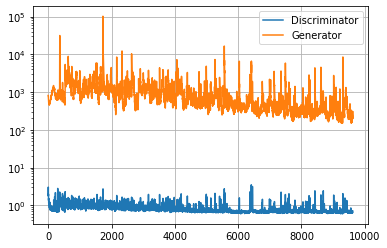

In [61]:
if ALPHA:
  label_loss = 'MSE+KL'
else:
  label_loss= 'MSE'
plt.plot(d_costs,label="Discriminator")
plt.plot(g_costs,label="Generator")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.savefig(root_output + "cost_vs_iteration.png")
plt.show()
plt.close()


# Testing

45463
(64, 64, 3)


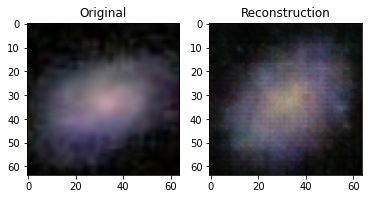

In [ ]:
# plot original and reconstruced images from test set
i = np.random.choice(len(x_train))
print(i)
x = x_train[i]
y = labels_train[i]
print(x.shape)
x_hat = VAE.predict([x.reshape(-1,img_dim,img_dim,colors),y.reshape(-1,labels_dim)])
plt.figure(figsize=(6,8))
plt.subplot(1,2,1)
if colors ==3:
  plt.imshow(x)
else:
  plt.imshow(x.reshape(img_dim,img_dim), cmap='gray')
plt.grid(False)
plt.title("Original")
plt.subplot(1,2,2)
if colors ==3:
  plt.imshow(x_hat.reshape(img_dim,img_dim,colors))
else:
  plt.imshow(x_hat.reshape(img_dim,img_dim), cmap='gray')
plt.grid(False)
plt.title("Reconstruction")
plt.show()

[44665 33075 28382 57461 49597 37531 25485 24464  3592 50383 57233  5909]


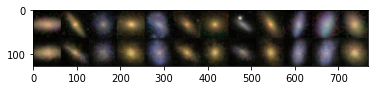

In [ ]:
d = img_dim
res = 12
flat_image = np.empty((2*d, res*d, 3))
samples = np.random.choice(len(x_train),res)
print(samples)
for i in range(res):
  x = x_train[samples[i]]
  y = labels_train[samples[i]]
  x_hat = VAE.predict([x.reshape(-1,img_dim,img_dim,colors),y.reshape(-1,labels_dim)])
  flat_image[0*d:(0+1)*d, i*d:(i+1)*d] = x.reshape(img_dim,img_dim,colors)
  flat_image[1*d:(1+1)*d, i*d:(i+1)*d] = x_hat.reshape(img_dim,img_dim,colors)
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
a = encoder.predict(x_train)

In [ ]:
a = np.asarray(a)

In [ ]:
a.shape

(2, 61578, 8)

In [ ]:
x_ind = 6
y_ind = x_ind + 1

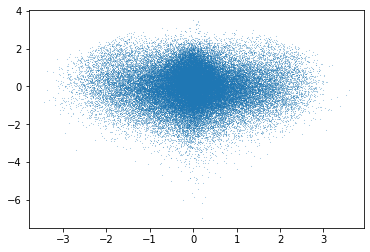

In [ ]:
m_x = a[0,:,x_ind]
#m_x = a[:,0]
m_y = a[0,:,y_ind]
#m_y = a[:,1]
plt.plot(m_x,m_y,'*',markersize=0.1)

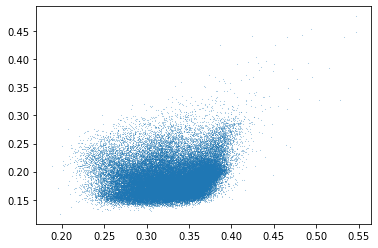

In [ ]:
s_x = a[1,:,x_ind]
s_y = a[1,:,y_ind]
plt.plot(s_x,s_y,'*',markersize=0.1)

In [ ]:
latent_stat = np.zeros((latent_dim,4))
for i in range(latent_dim):
  latent_stat[i][0] = np.mean(a[0,:,i])
  latent_stat[i][1] = np.std(a[0,:,i])
  latent_stat[i][2] = np.max(a[0,:,i])
  latent_stat[i][3] = np.min(a[0,:,i])
#latent_stat

In [ ]:
latent_stat.shape

(8, 4)

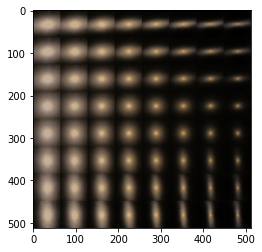

In [ ]:
d = 64
res = 8
flat_image = np.empty((res*d, res*d, 3))
x_ind = 6
y_ind = x_ind + 1
scale = 1
x_init = -3*scale
y_init = -3*scale
step_x = 2*abs(x_init)/(res-1)
step_y = 2*abs(y_init)/(res-1)
for i in range(res):
  for j in range(res):
    center_x = x_init +i*step_x
    center_y = y_init +j*step_y
    #random_latent = np.zeros((1,latent_dim))
    random_latent = np.array(latent_stat[:,0]).reshape(-1,latent_dim)
    random_latent[0,x_ind] = center_x
    random_latent[0,y_ind] = center_y
    random_sample = decoder.predict(random_latent)
    #random_sample = decoder.predict(np.array([latent_stat[0,0],latent_stat[1,0],center_x,center_y]).reshape(-1,latent_dim))
    random_sample.reshape(64,64,3)
    flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = random_sample
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
#cc = decoder.predict(np.array([1,1]).reshape(-1,2))


In [ ]:
x_enc = a[0,:,:]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=latent_dim,svd_solver ="full")
pca.fit(x_enc)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [ ]:
x_enc_trans = pca.transform(x_enc)
x_enc_hat = pca.inverse_transform(x_enc_trans)

In [ ]:
np.linalg.norm(x_enc - x_enc_hat)

0.00024167926

In [ ]:
x_enc_trans.shape

(61578, 8)

In [ ]:
pca.explained_variance_ratio_

array([2.5310370e-01, 2.2244810e-01, 2.0950554e-01, 1.5956390e-01,
       1.1207318e-01, 4.2828392e-02, 2.7161901e-04, 2.0564931e-04],
      dtype=float32)

In [ ]:
pca.explained_variance_

array([1.0335034e+00, 9.0832680e-01, 8.5547823e-01, 6.5155047e-01,
       4.5763069e-01, 1.7488204e-01, 1.1091074e-03, 8.3973195e-04],
      dtype=float32)

In [ ]:
pca.singular_values_

array([252.26978, 236.49956, 229.5164 , 200.30109, 167.86758, 103.7724 ,
         8.26411,   7.19084], dtype=float32)

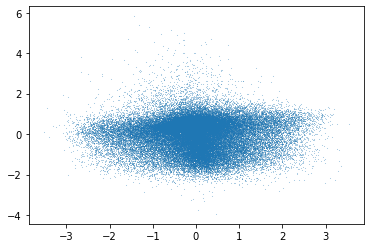

In [ ]:
x_ind = 2
y_ind = x_ind + 1
m_x = x_enc_trans[:,x_ind]
#m_x = a[:,0]
m_y = x_enc_trans[:,y_ind]
#m_y = a[:,1]
plt.plot(m_x,m_y,'*',markersize=0.1)

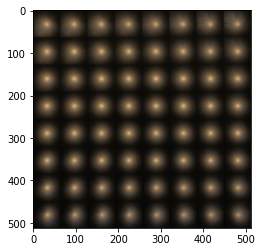

In [ ]:
d = 64
res = 8
flat_image = np.empty((res*d, res*d, 3))
x_ind = 4
y_ind = x_ind + 1
scale = 1
x_init = -3*scale
y_init = -3*scale
step_x = 2*abs(x_init)/(res-1)
step_y = 2*abs(y_init)/(res-1)
for i in range(res):
  for j in range(res):
    center_x = x_init +i*step_x
    center_y = y_init +j*step_y
    random_latent = np.zeros((1,latent_dim))
    #random_latent = np.array(latent_stat[:,0]).reshape(-1,latent_dim)

    random_latent = pca.transform(random_latent)

    random_latent[0,x_ind] = center_x
    random_latent[0,y_ind] = center_y
    #random_sample = decoder.predict(random_latent)
    random_sample = decoder.predict(pca.inverse_transform(random_latent))
    random_sample.reshape(64,64,3)
    flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = random_sample
plt.imshow(flat_image)
plt.grid(False)

## Interpolation

In [ ]:
from scipy.stats import norm

def lerp(val, low, high):
    """Linear interpolation"""
    return low + (high - low) * val

def lerp_gaussian(val, low, high):
    """Linear interpolation with gaussian CDF"""
    low_gau = norm.cdf(low)
    high_gau = norm.cdf(high)
    lerped_gau = lerp(val, low_gau, high_gau)
    return norm.ppf(lerped_gau)

def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    elif np.allclose(low, high):
        return low
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

def slerp_gaussian(val, low, high):
    """Spherical interpolation with gaussian CDF (generally not useful)"""
    offset = norm.cdf(np.zeros_like(low))  # offset is just [0.5, 0.5, ...]
    low_gau_shifted = norm.cdf(low) - offset
    high_gau_shifted = norm.cdf(high) - offset
    circle_lerped_gau = slerp(val, low_gau_shifted, high_gau_shifted)
    epsilon = 0.001
    clipped_sum = np.clip(circle_lerped_gau + offset, epsilon, 1.0 - epsilon)
    result = norm.ppf(clipped_sum)
    return result


45514 5329


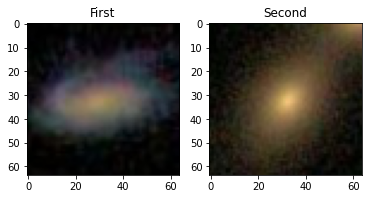

In [ ]:
#id_1 = 0
#id_2 = 9
#id_1 = np.random.choice(len(x_train))
#id_2 = np.random.choice(len(x_train))
print(id_1,id_2)
x_1 = x_train[id_1]
x_2 = x_train[id_2]
plt.figure(figsize=(6,8))
plt.subplot(1,2,1)
plt.imshow(x_1)
plt.grid(False)
plt.title("First")
plt.subplot(1,2,2)
plt.imshow(x_2)
plt.grid(False)
plt.title("Second")
plt.show()

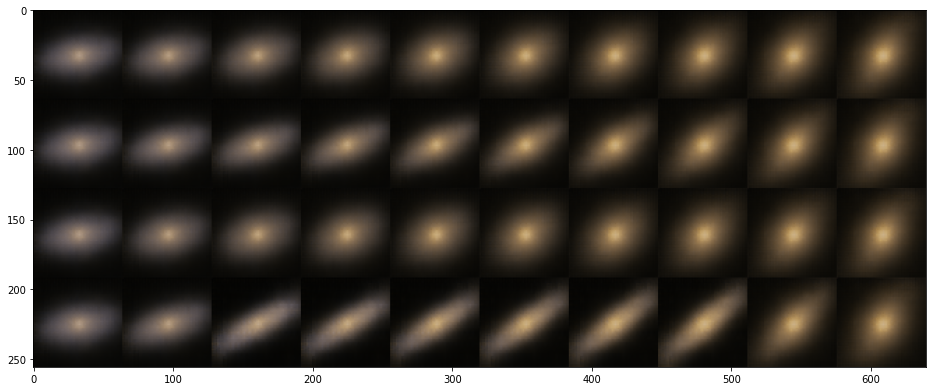

In [ ]:
## Interpolation in the latent space
d = 64
res = 10
flat_image = np.empty((4*d, res*d, 3))
latent_1 = x_enc[id_1]
latent_2 = x_enc[id_2]
plt.figure(figsize=(16,8))
for i in range(res):
  latent_interpolate_lin = lerp(i/(res-1), latent_1, latent_2)
  latent_interpolate_sph = slerp(i/(res-1), latent_1, latent_2)
  latent_interpolate_linG = lerp_gaussian(i/(res-1), latent_1, latent_2)
  latent_interpolate_sphG = slerp_gaussian(i/(res-1), latent_1, latent_2)
  sample_interpolate_lin = decoder.predict(latent_interpolate_lin.reshape(-1,latent_dim))
  sample_interpolate_sph = decoder.predict(latent_interpolate_sph.reshape(-1,latent_dim))
  sample_interpolate_linG = decoder.predict(latent_interpolate_linG.reshape(-1,latent_dim))
  sample_interpolate_sphG = decoder.predict(latent_interpolate_sphG.reshape(-1,latent_dim))
  flat_image[0*d:(0+1)*d, i*d:(i+1)*d] = sample_interpolate_lin.reshape(64,64,3)
  flat_image[1*d:(1+1)*d, i*d:(i+1)*d] = sample_interpolate_sph.reshape(64,64,3)
  flat_image[2*d:(2+1)*d, i*d:(i+1)*d] = sample_interpolate_linG.reshape(64,64,3)
  flat_image[3*d:(3+1)*d, i*d:(i+1)*d] = sample_interpolate_sphG.reshape(64,64,3)
plt.imshow(flat_image)
plt.grid(False)

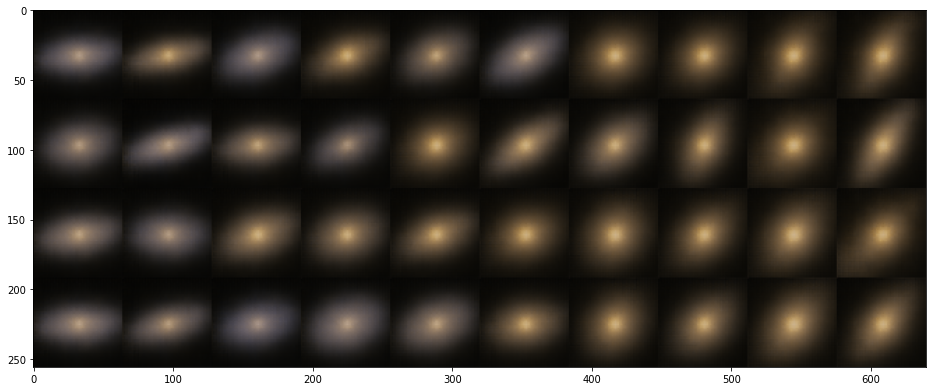

In [ ]:
## Interpolation in the input space
d = 64
res = 10
flat_image = np.empty((4*d, res*d, 3))
x_1 = x_1.ravel()
x_2 = x_2.ravel()
# original 3d dim or faltten or ravel or reshape?? why the difference between all (because of the randomness in VAE not the diffrence in reshape funcitons)
plt.figure(figsize=(16,8))
for i in range(res):
  input_interpolate_lin = lerp(i/(res-1), x_1, x_2)
  input_interpolate_sph = slerp(i/(res-1), x_1, x_2)
  input_interpolate_linG = lerp_gaussian(i/(res-1), x_1, x_2)
  input_interpolate_sphG = slerp_gaussian(i/(res-1), x_1, x_2)
  sample_input_interpolate_lin = VAE.predict(input_interpolate_lin.reshape(-1,64,64,3))
  sample_input_interpolate_sph = VAE.predict(input_interpolate_sph.reshape(-1,64,64,3))
  sample_input_interpolate_linG = VAE.predict(input_interpolate_linG.reshape(-1,64,64,3))
  sample_input_interpolate_sphG = VAE.predict(input_interpolate_sphG.reshape(-1,64,64,3))
  flat_image[0*d:(0+1)*d, i*d:(i+1)*d] = sample_input_interpolate_lin.reshape(64,64,3)
  flat_image[1*d:(1+1)*d, i*d:(i+1)*d] = sample_input_interpolate_sph.reshape(64,64,3)
  flat_image[2*d:(2+1)*d, i*d:(i+1)*d] = sample_input_interpolate_linG.reshape(64,64,3)
  flat_image[3*d:(3+1)*d, i*d:(i+1)*d] = sample_input_interpolate_sphG.reshape(64,64,3)
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
from sklearn.cluster import KMeans
n_clustres = 4
kmeans = KMeans(n_clusters=n_clustres, random_state=0).fit(x_enc)

In [ ]:
centroids = kmeans.cluster_centers_
centroids

In [ ]:
plt.plot(m_x,m_y,'*',markersize=0.1)
for center in centroids:
  plt.plot(center[0],center[1],'o', markersize=5)


In [ ]:
labels = kmeans.labels_
labels

In [ ]:
indices = list(np.arange(n_clustres))
for i in range(n_clustres):
  indices[i] = np.where(labels == i)

In [ ]:
indices

In [ ]:
# plot cluster images
cluster = 3
print("Cluster: ",cluster)
print(centroids[cluster])
samples = np.random.choice(np.asarray(indices[cluster]).ravel(),10)
print(samples)
for i, sample in enumerate(samples):
  x = x_train[sample]
  plt.subplot(2,5,i+1)
  plt.imshow(x)
  plt.grid(False)

In [ ]:
for i, sample in enumerate(samples):
  x = x_train[sample]
  x_hat = VAE.predict(x.reshape(-1,64,64,3))
  plt.subplot(2,5,i+1)
  plt.imshow(x_hat.reshape(64, 64,3))
  plt.grid(False)

In [ ]:
aa = np.random.choice(30,12)

In [ ]:
aa

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
aa.reshape((1,2,2,3))

array([[[[13, 22, 19],
         [ 8,  4, 12]],

        [[14, 28, 29],
         [ 9, 28,  6]]]])

In [ ]:
aa_f = aa.flatten()
aa_f

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
aa

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
aa_r = aa.ravel()
aa_r

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
aa

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
x_1.shape

(64, 64, 3)

In [ ]:
x_1[0].shape

(64, 3)

In [ ]:
K.image_data_format()

'channels_last'